# Assignment - 03
### Group ID: 09
### Group Members Name with Student ID:

| Student Name       | Student ID    | Contribution |
|--------------------|---------------|--------------|
| Shivam Sahil            | 2023aa05280   | 100%         |
| Gali Jahnavi       | 2023aa05684   | 100%         |
| Michael Joshua     | 2023aa05023   | 100%         |

## Subject - Video Analytics

In [2]:
# Import necessary libraries
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # To avoid SSL error checks
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from re import search as search_regex
from ultralytics import YOLO
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Dropout
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.signal import savgol_filter
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
import kagglehub
from datetime import datetime
from math import sqrt
from matplotlib import gridspec
from collections import defaultdict
from matplotlib.collections import LineCollection
import random

/Users/shivamsahil/Downloads/bits/assignments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Common Utilities
def get_dataset_path():
    return r'tennis_player_dataset'

In [5]:
def get_environment_and_shot_name_from_file_name(file_name):
    environment_name = "outdoor"
    shot_name = "straight"
    if("virtual field" in file_name.lower()):
        environment_name = "virtual"
    if("crosscourt shot" in file_name.lower()): # File name comes as - tennis_player_dataset/Virtual Field - Crosscourt Shot.csv
        shot_name = "cross"
    
    return environment_name, shot_name

def get_environment_from_video_file_path(path_parts):
    environment = "outdoor"
    shot_name = "straight"
    view_name = "top"
    # Extract metadata
    envID = path_parts[0]  # "outdoor field" or "virtual field"
    shotID = path_parts[1]  # "cross court shot" or "straight shot"
    viewID = path_parts[2]  # "side view" or "top view"
    fileID = path_parts[3][0:3] # OCT / OCS / OSS etc
    
    if "virtual" in envID.lower():
        environment = "virtual"
    if "cross-court" in shotID.lower():
        shot_name = "cross"
    if "side" in viewID.lower():
        view_name = "side"
        
    return environment, shot_name, view_name, fileID
    
def load_dataset(data_path):
    """
    Load video files and annotations from the dataset
    
    Parameters:
    data_path (str): Path to the root folder containing the dataset
    
    Returns:
    videos (list): List of dictionaries containing video information
    annotations (list): List of dictionaries containing annotation information
    """
    videos = []
    annotations = []
    
    # Define video file extensions
    video_extensions = ['.mp4', '.avi', '.mov']
    
    # Find all CSV files at the root level
    csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    
    # Dictionary to store loaded CSV data
    csv_data = {}
    
    # Load all CSV files
    for csv_file in csv_files:
        csv_path = os.path.join(data_path, csv_file)
        df = pd.read_csv(csv_path)
        environment, shot_type = get_environment_and_shot_name_from_file_name(csv_path)        
        # Store the dataframe with a key that we can match to video folders
        key = f"{environment}/{shot_type}"
        csv_data[key] = df
    
    # Walk through all directories
    for root, dirs, files in os.walk(data_path):
        for file in files:
            # Check if file is a video
            if any(file.lower().endswith(ext) for ext in video_extensions):
                # Get the full path to the video
                video_path = os.path.join(root, file)
                
                # Extract metadata from path
                rel_path = os.path.relpath(video_path, data_path)
                path_parts = rel_path.split(os.sep)                
                # Skip if not enough path parts to determine metadata
                if len(path_parts) < 4:
                    continue
                
                # Extract metadata
                environment, shot_folder, view_type, shot_descriptor = get_environment_from_video_file_path(path_parts)
                
                file_name = os.path.splitext(file)[0]
                match = search_regex(r'\d+', file_name)
                if not match:
                    raise ValueError(f'Got Invalid file name: %s, Expected in OCS/OCT format' % file_name)
                video_index = int(match.group())                
                # Create a lookup key for CSV data
                lookup_key = f"{environment}/{shot_folder}"
                # print('kk<-',lookup_key)
                
                
                # Check if we have annotations for this video
                annotation_data = None
                if lookup_key in csv_data and 0 <= video_index - 1 < len(csv_data[lookup_key]):
                    # Get the annotation row for this video (index-1 because CSV is 1-indexed)
                    annotation_data = csv_data[lookup_key].iloc[video_index - 1].to_dict()
                else: 
                    print(f'Lookup key: {lookup_key} || {video_index}')
                
                # Load video metadata
                cap = cv2.VideoCapture(video_path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                cap.release()
                
                # Create video info dictionary
                video_info = {
                    'path': video_path,
                    'environment': environment,
                    'shot_type': shot_folder,
                    'view_type': view_type,
                    'shot_descriptor': shot_descriptor,
                    'index': video_index,
                    'frame_count': frame_count,
                    'width': width,
                    'height': height,
                    'fps': fps
                }
                
                videos.append(video_info)
                
                # If we have annotation data, add it
                if annotation_data is not None:
                    annotation_info = {
                        'video_path': video_path,
                        'index': video_index,
                        'to_sideline_distance': annotation_data['To-Closest-Doubles-Sideline-Distance (m)'],
                        'to_baseline_distance': annotation_data['To-Baseline-Distance (m)']
                    }
                    annotations.append(annotation_info)
    
    print(f"Loaded {len(videos)} videos and {len(annotations)} annotations")
    return videos, annotations

def visualize_annotations(frame, annotation, court_dimensions=None):
    """
    Draw annotations on a tennis court frame
    
    Parameters:
    frame (numpy.ndarray): The video frame to annotate
    annotation (dict): Annotation data containing court positions
    court_dimensions (tuple, optional): (width, height) of court in meters for scaling
    
    Returns:
    annotated_frame (numpy.ndarray): Frame with annotations drawn
    """
    # Make a copy of the frame to avoid modifying the original
    annotated_frame = frame.copy()
    
    # If no annotation, return the original frame
    if annotation is None:
        return annotated_frame
    
    # Get frame dimensions
    h, w = annotated_frame.shape[:2]
    
    # Default court dimensions if not provided
    if court_dimensions is None:
        # Standard tennis court: 23.77m x 10.97m (singles)
        court_dimensions = (23.77, 10.97)
    
    # Extract distances from annotation
    sideline_distance = annotation['to_sideline_distance']
    baseline_distance = annotation['to_baseline_distance']
    
    # Calculate approximate player position in the frame
    # This is a simplification and will need to be adjusted for your specific setup
    
    # For side view (adjust these constants based on your specific videos)
    if 'side' in annotation['video_path']:
        # In side view, x corresponds to baseline distance and y is fixed
        x_ratio = baseline_distance / court_dimensions[0]
        x_pos = int(w * (1 - x_ratio))  # Assuming baseline is on the right
        y_pos = int(h * 0.8)  # Fixed height for side view (adjust as needed)
    
    # For top view
    else:
        # In top view, x corresponds to sideline distance and y to baseline distance
        x_ratio = sideline_distance / court_dimensions[1]
        y_ratio = baseline_distance / court_dimensions[0]
        
        x_pos = int(w * x_ratio)
        y_pos = int(h * y_ratio)
    
    # Draw the player position (red circle)
    cv2.circle(annotated_frame, (x_pos, y_pos), 20, (0, 0, 255), -1)
    
    # Add text with distances
    text = f"Sideline: {sideline_distance:.2f}m, Baseline: {baseline_distance:.2f}m"
    cv2.putText(annotated_frame, text, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Draw court grid (optional, for better visualization)
    # Horizontal lines (baselines and service lines)
    cv2.line(annotated_frame, (0, int(h*0.2)), (w, int(h*0.2)), (0, 255, 0), 1)  # Far baseline
    cv2.line(annotated_frame, (0, int(h*0.8)), (w, int(h*0.8)), (0, 255, 0), 1)  # Near baseline
    
    # Vertical lines (sidelines and center line)
    cv2.line(annotated_frame, (int(w*0.25), 0), (int(w*0.25), h), (0, 255, 0), 1)  # Left sideline
    cv2.line(annotated_frame, (int(w*0.5), 0), (int(w*0.5), h), (0, 255, 0), 1)    # Center line
    cv2.line(annotated_frame, (int(w*0.75), 0), (int(w*0.75), h), (0, 255, 0), 1)  # Right sideline
    
    return annotated_frame

In [6]:
# Load Video Annotations
data_path = get_dataset_path()
videos, annotations = load_dataset(data_path)
# Docs reference - https://www.perplexity.ai/search/what-is-oct-ocs-oss-ost-in-ten-Dj9bu0BIT7axbNk6r7rOSg

Loaded 472 videos and 472 annotations


## 1. Player Detection and Tracking
Implement algorithms to detect and track tennis players throughout a match.

a) Develop a player detection model using a deep learning approach (e.g., YOLO, Faster R-CNN).

b) Implement a tracking algorithm to maintain player identities across frames.

c) Handle occlusions and camera movement typical in broadcast footage.

d) Evaluate your algorithm's performance against the provided ground truth annotations.

In [7]:
# Develop a player detection model using a deep learning approach (e.g., YOLO, Faster R-CNN).
# We're using YOLO along with Kalman Detector to detect and track person

model = YOLO("yolov8n.pt")



# ---------------------------
# Implement a tracking algorithm to maintain player identities across frames.
# Kalman Filter for 2D tracking
# ---------------------------
class KalmanFilter2D:
    def __init__(self, x, y, vx=0, vy=0):
        self.state = np.array([[x], [y], [vx], [vy]], dtype=np.float32)
        self.F = np.array([[1, 0, 1, 0],
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * 0.01
        self.R = np.eye(2, dtype=np.float32) * 5.0
        self.P = np.eye(4, dtype=np.float32)

    def predict(self):
        self.state = np.dot(self.F, self.state)
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.state

    def update(self, z):
        y = z.reshape(-1, 1) - np.dot(self.H, self.state)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state += K @ y
        I = np.eye(self.P.shape[0], dtype=np.float32)
        self.P = (I - K @ self.H) @ self.P

def get_center(box):
    cx = (box[0] + box[2]) / 2
    cy = (box[1] + box[3]) / 2
    return np.array([cx, cy], dtype=np.float32)

# ---------------------------
# Handle occlusions and camera movement typical in broadcast footage.
# Track class for strongest detection
# ---------------------------
class Track:
    def __init__(self, track_id, box):
        cx, cy = get_center(box)
        self.kf = KalmanFilter2D(cx, cy)
        self.box = box
        self.id = track_id
        self.misses = 0

    def predict_and_update(self, box=None):
        self.kf.predict()
        if box is not None:
            cx, cy = get_center(box)
            self.kf.update(np.array([cx, cy], dtype=np.float32))
            self.box = box
            self.misses = 0
        else:
            self.misses += 1


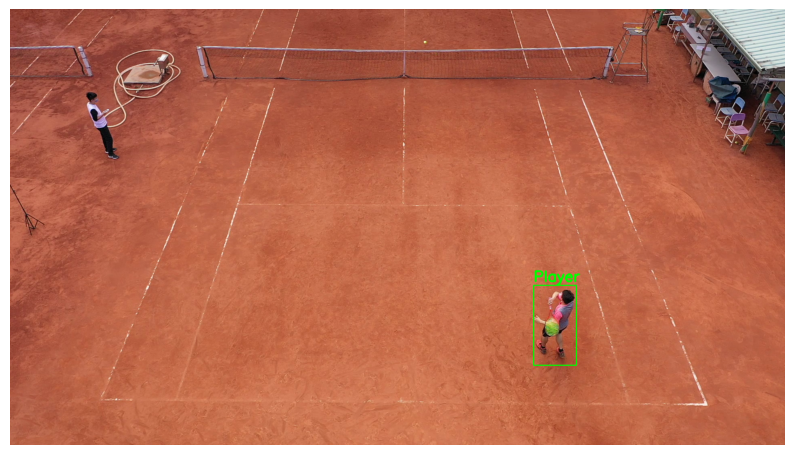

In [8]:
# ---------------------------
# Running tracking in one of the sample videos
# ---------------------------
video = videos[8]
path = video['path']
cap = cv2.VideoCapture(path)

track = None
next_id = 0
MAX_MISSES = 10

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(frame, conf=0.5, imgsz=640)[0]
    boxes = results.boxes.xyxy.cpu().numpy()
    confs = results.boxes.conf.cpu().numpy() if hasattr(results.boxes, 'conf') else [1.0] * len(boxes)
    
    detections = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        conf = confs[i]
        detections.append([x1, y1, x2, y2, conf])
    
    # Find the strongest detection only if we haven't set a track yet.
    if track is None and detections:
        strongest_detection = max(detections, key=lambda d: d[4])
        strongest_box = strongest_detection[:4]
        track = Track(next_id, strongest_box)
        next_id += 1
    else:
        # Once the track is set, ignore new detections and simply predict.
        track.predict_and_update(None)
        if track.misses > MAX_MISSES:
            track = None

    # Visualization
    if track is not None:
        x1, y1, x2, y2 = track.box
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, f"Player", (int(x1), int(y1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()

cap.release()
cv2.destroyAllWindows()

## 2. Shot Classification and Analysis

Develop a system to classify different tennis shots and analyze their characteristics.

a) Implement a machine learning model to classify shot types (e.g., serve, forehand, backhand, volley).

b) Extract relevant features for each shot (e.g., player pose, racket position, ball trajectory).

c) Analyze shot patterns and their effectiveness based on court position and game context.

d) Visualize shot distributions and success rates for each player.

In [167]:
def combine_video_and_annotations():
    # Assumes that video and annotations are already processed
    combined_data = []
    for index, video in enumerate(videos):
        combined_data.append({
            **video,
            **{
                'to_sideline_distance': annotations[index]['to_sideline_distance'],
                'to_baseline_distance': annotations[index]['to_baseline_distance'],
            }
        })
    return combined_data

In [168]:
# Cell 3: Define a function to load and process video frames.
def extract_frames(video_path, num_frames=20):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    for i in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (224, 224))
            frame = frame / 255.0  # Normalize
            frames.append(frame)
    
    cap.release()
    return np.array(frames)

# Cell 4: Prepare the dataset using the video_data list.
# Cell: Prepare the dataset as before
def prepare_shot_classification_data(video_data):
    X = []
    y = []
    # Map shot descriptors to numerical labels
    shot_types = {'forehand': 0, 'backhand': 1, 'serve': 2, 'volley': 3}
    env_set = set()
    
    for data in tqdm(video_data, desc="Processing videos"):
        # Normalize the shot descriptor to ensure consistent matching
        shot_desc = data['shot_descriptor'].strip().upper()
        
        # Map shot descriptor to shot type
        if 'OCT' in shot_desc:  # Example mapping - adjust as needed
            shot_type = 'forehand'
        elif 'OST' in shot_desc:
            shot_type = 'backhand'
        elif 'OCS' in shot_desc:
            shot_type = 'volley'
        else:
            shot_type = 'serve'
            
        # Extract frames using your function (ensure extract_frames is defined)
        frames = extract_frames(data['path'])
        X.append(frames)
        
        # Track environment information
        env = data['environment'].strip().lower()
        env_set.add(env)
        
        # Append the corresponding label
        y.append(shot_types.get(shot_type, 0))
    
    return np.array(X), np.array(y), list(env_set)

# Create the shot classification model
def create_shot_classification_model(num_frames=20, num_classes=4):
    # Base model for feature extraction
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    # Create a time-distributed model to process each frame
    model = Sequential([
        TimeDistributed(base_model, input_shape=(num_frames, 224, 224, 3)),
        TimeDistributed(Flatten()),
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train shot classification model
def train_shot_classifier(X, y, env_list):
    train_indices = [i for i, env in enumerate(env_list) if env.lower() == 'virtual']
    test_indices = [i for i, env in enumerate(env_list) if env.lower() == 'outdoor']

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    print('Test Train Split done')
    
    model = create_shot_classification_model()
    print('Model Created')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=8
    )
    
    return model, history



In [169]:
# Build the dataset
video_data = combine_video_and_annotations()

In [170]:
# Build the dataset
X, y, env_list = prepare_shot_classification_data(video_data)

Processing videos: 100%|██████████| 472/472 [07:22<00:00,  1.07it/s]


In [171]:
model, history = train_shot_classifier(X, y, env_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.0000e+00 - loss: 2.3170 - val_accuracy: 1.0000 - val_loss: 1.0437
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 1.0000 - loss: 0.7918 - val_accuracy: 1.0000 - val_loss: 0.6368
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 1.0000 - loss: 0.5315 - val_accuracy: 1.0000 - val_loss: 0.3087
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 1.0000 - loss: 0.2508 - val_accuracy: 1.0000 - val_loss: 0.1445
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0823
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - accuracy: 1.0000 - loss: 0.0878 - val_accuracy: 1.0000 - val_loss: 0.0519
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - accuracy: 1.0000 - loss: 0.1413 - val_accuracy: 1.0000 - val_loss: 0.0346
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0241


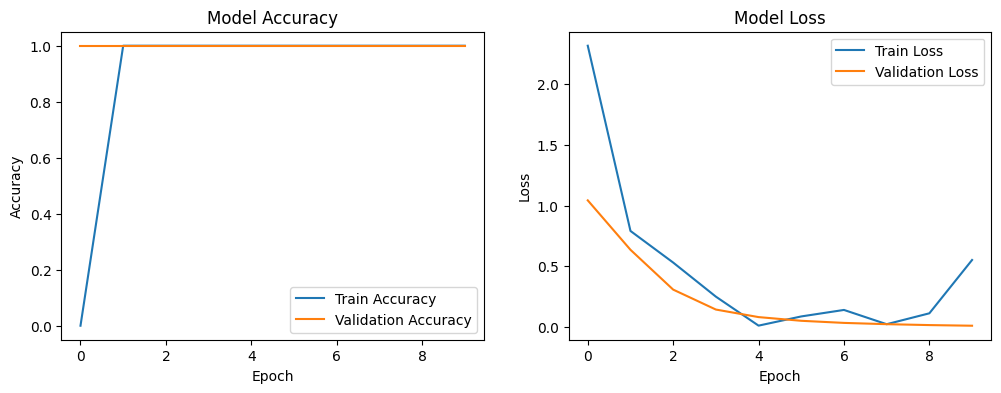

In [172]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## B) Feature Extraction for Shot Analysis
Let's implement feature extraction for tennis shots, including player pose, racket position, and ball trajectory.

In [173]:
# Loading pre-trained model for pose estimation
def load_pose_model():
    model_path = kagglehub.model_download("google/movenet/tensorFlow2/singlepose-lightning")
    model = tf.saved_model.load(model_path)
    movenet = model.signatures['serving_default']
    return movenet

# Function to detect player pose
def detect_pose(frame, pose_model):
    # Prepare input frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = tf.image.resize_with_pad(np.expand_dims(frame_rgb, axis=0), 192, 192)
    input_img = tf.cast(frame_resized, dtype=tf.int32)
    
    # Get pose results
    results = pose_model(input_img)
    keypoints = results['output_0'].numpy()[0, 0, :, :2]  # Taking only x, y coordinates
    
    return keypoints

# Function to track ball trajectory
def track_ball(video_path):
    cap = cv2.VideoCapture(video_path)
    
    # Parameters for ball detection
    ball_positions = []
    
    # Define the lower and upper bounds for tennis ball color (adjust based on your video)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Create mask for yellow color
        mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
        
        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find largest contour (assuming it's the ball)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            if cv2.contourArea(largest_contour) > 30:  # Minimum area threshold
                ((x, y), radius) = cv2.minEnclosingCircle(largest_contour)
                ball_positions.append((int(x), int(y)))
    
    cap.release()
    
    # Smooth trajectory using Savitzky-Golay filter if enough points
    if len(ball_positions) > 10:
        x_coords = [pos[0] for pos in ball_positions]
        y_coords = [pos[1] for pos in ball_positions]
        
        x_smooth = savgol_filter(x_coords, 15, 2)
        y_smooth = savgol_filter(y_coords, 15, 2)
        
        smooth_positions = [(int(x), int(y)) for x, y in zip(x_smooth, y_smooth)]
        return smooth_positions
    
    return ball_positions

In [174]:
# Function to detect racket position and shot types
def detect_racket(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area and aspect ratio to find the racket
    racket_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Minimum area threshold
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            
            if 0.2 < aspect_ratio < 1.5:  # Aspect ratio for a tennis racket
                racket_contour = contour
                break
    
    if racket_contour is not None:
        return cv2.boundingRect(racket_contour)
    return None

# Main function to extract features from a shot

## C) Shot Pattern Analysis
Now, let's analyze shot patterns and their effectiveness based on court position and game context.

In [175]:

def extract_shot_features(video_data):
    features = []
    pose_model = load_pose_model()
    
    for data in video_data:
        video_path = data['path']
        cap = cv2.VideoCapture(video_path)
        
        # Extract frames for analysis
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_indices = np.linspace(0, total_frames-1, 10, dtype=int)
        
        # Features for this video
        video_features = {
            'shot_type': data['shot_type'],
            'environment': data['environment'],
            'to_sideline_distance': data['to_sideline_distance'],
            'to_baseline_distance': data['to_baseline_distance'],
            'pose_keypoints': [],
            'racket_positions': [],
        }
        
        # Extract pose and racket positions from sample frames
        for idx in sample_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Detect pose
                keypoints = detect_pose(frame, pose_model)
                video_features['pose_keypoints'].append(keypoints)
                
                # Detect racket
                racket_pos = detect_racket(frame)
                if racket_pos:
                    video_features['racket_positions'].append(racket_pos)
        
        # Track ball trajectory
        ball_trajectory = track_ball(video_path)
        video_features['ball_trajectory'] = ball_trajectory
        
        # Calculate additional features
        video_features['shot_speed'] = calculate_shot_speed(ball_trajectory, data['fps'])
        video_features['shot_angle'] = calculate_shot_angle(ball_trajectory)
        
        features.append(video_features)
        cap.release()
    
    return features

# Calculate shot speed from ball trajectory
def calculate_shot_speed(ball_trajectory, fps):
    if len(ball_trajectory) < 2:
        return 0
    
    # Calculate distances between consecutive points
    distances = []
    for i in range(1, len(ball_trajectory)):
        x1, y1 = ball_trajectory[i-1]
        x2, y2 = ball_trajectory[i]
        dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        distances.append(dist)
    
    # Convert to speed (pixels per second)
    avg_distance = np.mean(distances)
    speed = avg_distance * fps
    
    # This would need calibration to convert to real-world units
    return speed

# Calculate shot angle from ball trajectory
def calculate_shot_angle(ball_trajectory):
    if len(ball_trajectory) < 2:
        return 0
    
    # Take first and last points to calculate overall direction
    x1, y1 = ball_trajectory[0]
    x2, y2 = ball_trajectory[-1]
    
    angle = np.arctan2(y2-y1, x2-x1) * 180 / np.pi
    return angle

In [176]:
def extract_shot_features(video_data):
    features = []
    pose_model = load_pose_model()
    
    for data in video_data:
        video_path = data['path']
        cap = cv2.VideoCapture(video_path)
        
        # Extract frames for analysis
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_indices = np.linspace(0, total_frames-1, 10, dtype=int)
        
        # Features for this video
        video_features = {
            'shot_type': data['shot_type'],
            'environment': data['environment'],
            'to_sideline_distance': data['to_sideline_distance'],
            'to_baseline_distance': data['to_baseline_distance'],
            'pose_keypoints': [],
            'racket_positions': [],
        }
        
        # Extract pose and racket positions from sample frames
        for idx in sample_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Detect pose
                keypoints = detect_pose(frame, pose_model)
                video_features['pose_keypoints'].append(keypoints)
                
                # Detect racket
                racket_pos = detect_racket(frame)
                if racket_pos:
                    video_features['racket_positions'].append(racket_pos)
        
        # Track ball trajectory
        ball_trajectory = track_ball(video_path)
        video_features['ball_trajectory'] = ball_trajectory
        
        # Calculate additional features
        video_features['shot_speed'] = calculate_shot_speed(ball_trajectory, data['fps'])
        video_features['shot_angle'] = calculate_shot_angle(ball_trajectory)
        
        features.append(video_features)
        cap.release()
    
    return features

# Calculate shot speed from ball trajectory
def calculate_shot_speed(ball_trajectory, fps):
    if len(ball_trajectory) < 2:
        return 0
    
    # Calculate distances between consecutive points
    distances = []
    for i in range(1, len(ball_trajectory)):
        x1, y1 = ball_trajectory[i-1]
        x2, y2 = ball_trajectory[i]
        dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        distances.append(dist)
    
    # Convert to speed (pixels per second)
    avg_distance = np.mean(distances)
    speed = avg_distance * fps
    
    # This would need calibration to convert to real-world units
    return speed

# Calculate shot angle from ball trajectory
def calculate_shot_angle(ball_trajectory):
    if len(ball_trajectory) < 2:
        return 0
    
    # Take first and last points to calculate overall direction
    x1, y1 = ball_trajectory[0]
    x2, y2 = ball_trajectory[-1]
    
    angle = np.arctan2(y2-y1, x2-x1) * 180 / np.pi
    return angle

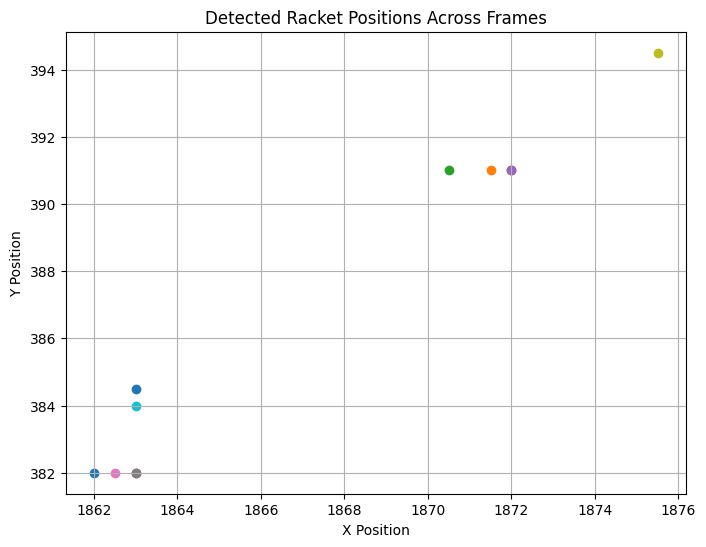

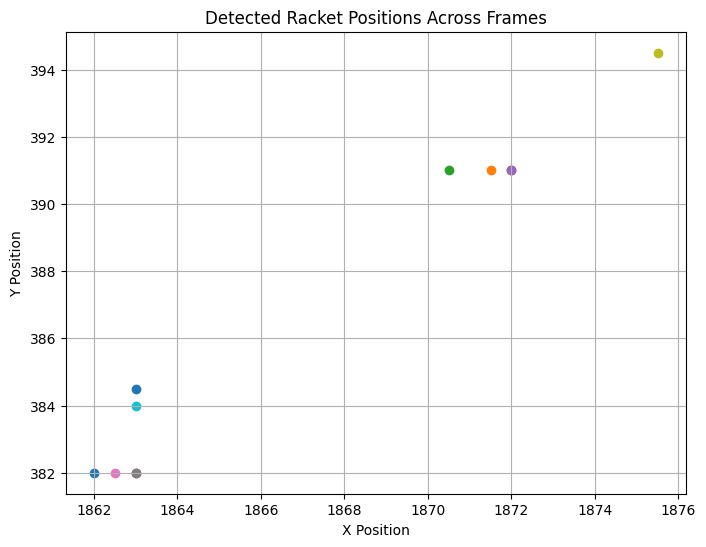

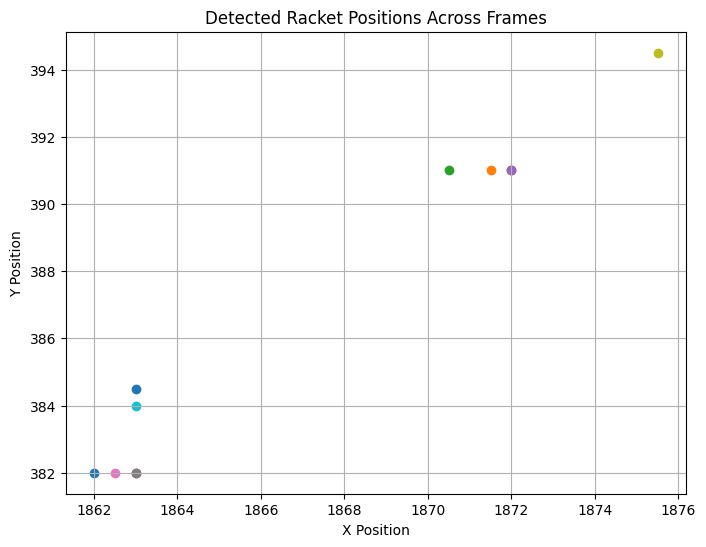

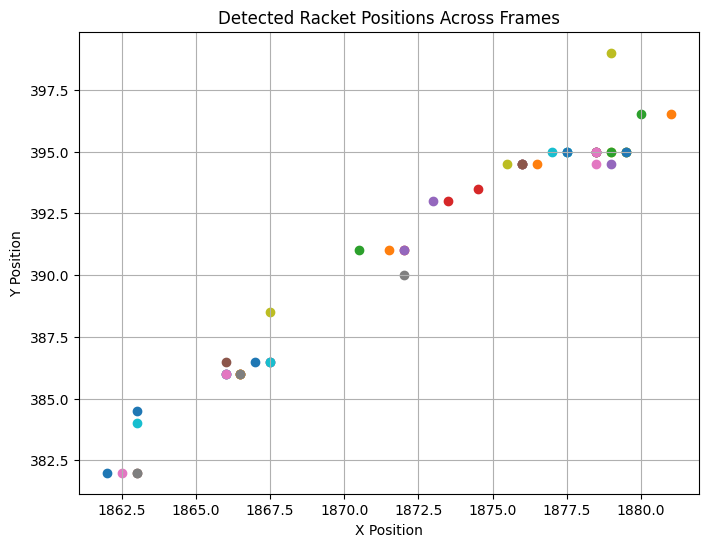

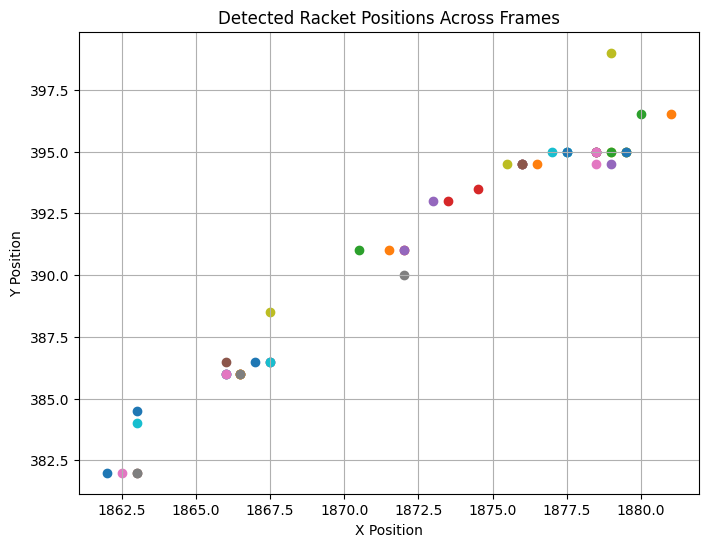

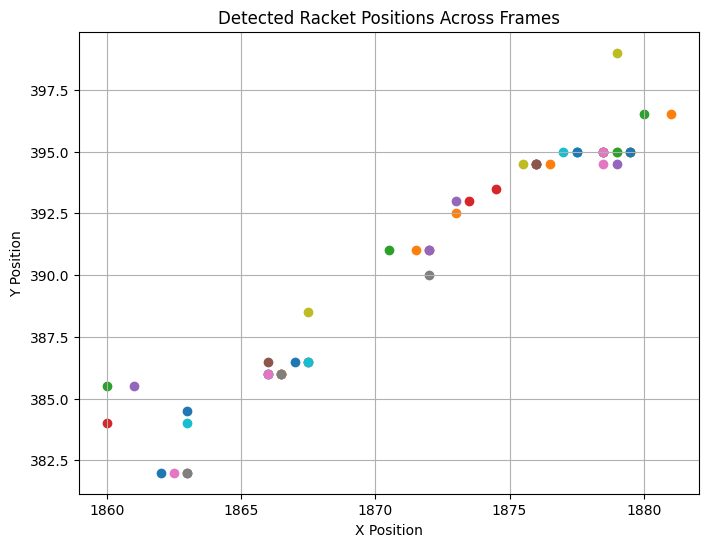

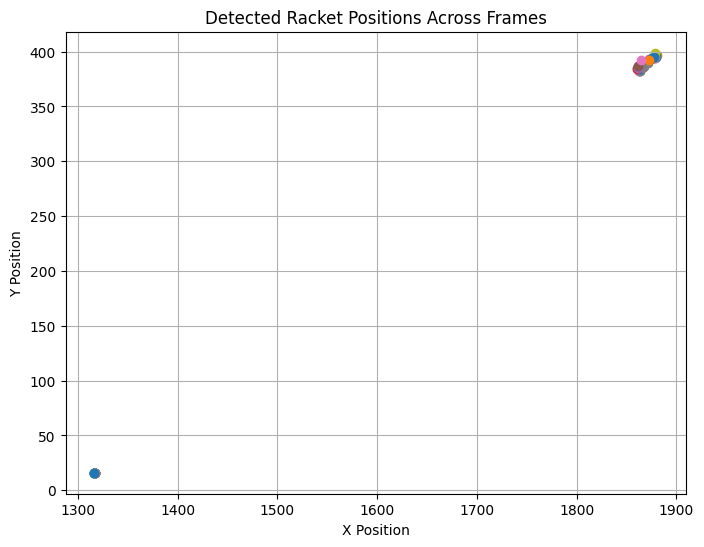

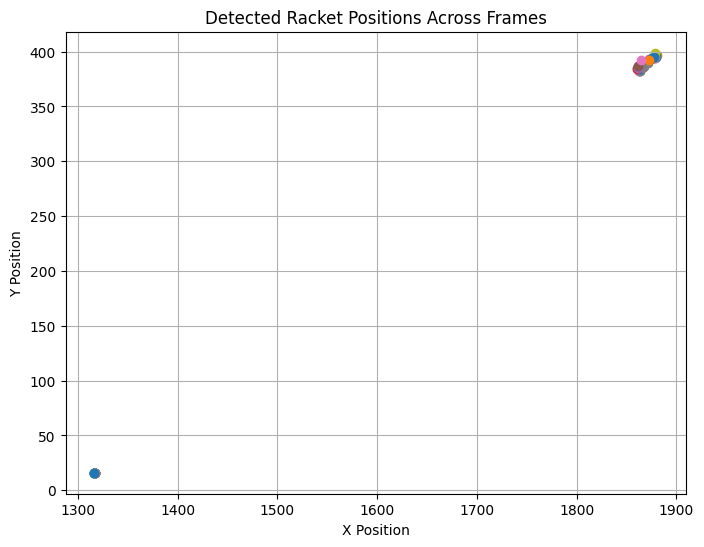

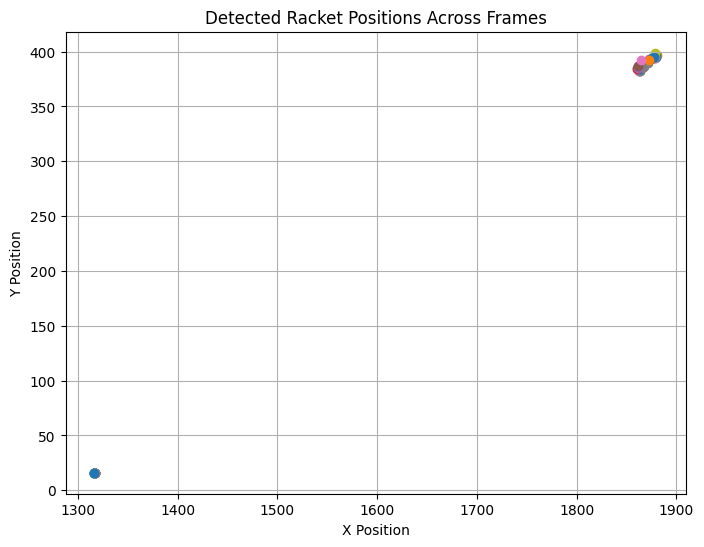

In [177]:
# VIsualising Racket Position for top N players in random video
# Extract key frame and detect racket position
racket_positions = []
# Extract the video
paths = [x['path'] for x in video_data[:9]] # 9 is picked randomly as it corresponds to group number
for path in paths:
    cap = cv2.VideoCapture(path)
    while True: # Show for first 5 frames
        ret, frame = cap.read()
        if not ret:
            break
        racket_pos = detect_racket(frame)
        if racket_pos:
            racket_positions.append(racket_pos)

    # Visualize the racket positions
    if racket_positions:
        plt.figure(figsize=(8, 6))
        for idx, (x, y, w, h) in enumerate(racket_positions):
            plt.scatter(x + w / 2, y + h / 2, label=f"Frame {idx+1}")  # Mark racket center
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Detected Racket Positions Across Frames")
        # plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No racket detected in the frames.")

In [178]:
shot_features = extract_shot_features(video_data)

## D) Visualize shot distributions and success rates for each player.
In this section we would visualize shot distributions and success rates for different players

In [179]:
# Convert features to a pandas DataFrame for easier analysis
def create_shot_dataframe(shot_features):
    # Extract relevant information for each shot
    data = []
    for feat in shot_features:
        # Basic shot info
        shot_info = {
            'shot_type': feat['shot_type'],
            'environment': feat['environment'],
            'to_sideline_distance': feat['to_sideline_distance'],
            'to_baseline_distance': feat['to_baseline_distance'],
            'shot_speed': feat['shot_speed'],
            'shot_angle': feat['shot_angle']
        }
        
        # Add average pose information (e.g., average hip and shoulder positions)
        if feat['pose_keypoints']:
            avg_keypoints = np.mean(feat['pose_keypoints'], axis=0)
            shot_info['right_shoulder_x'] = avg_keypoints[6, 0]
            shot_info['right_shoulder_y'] = avg_keypoints[6, 1]
            shot_info['left_shoulder_x'] = avg_keypoints[5, 0]
            shot_info['left_shoulder_y'] = avg_keypoints[5, 1]
            shot_info['right_hip_x'] = avg_keypoints[12, 0]
            shot_info['right_hip_y'] = avg_keypoints[12, 1]
            shot_info['left_hip_x'] = avg_keypoints[11, 0]
            shot_info['left_hip_y'] = avg_keypoints[11, 1]
            
            # Calculate body rotation (angle between shoulders)
            if len(avg_keypoints) > 6:
                right_shoulder = avg_keypoints[6]
                left_shoulder = avg_keypoints[5]
                shoulder_angle = np.arctan2(
                    right_shoulder[1] - left_shoulder[1],
                    right_shoulder[0] - left_shoulder[0]
                ) * 180 / np.pi
                shot_info['shoulder_angle'] = shoulder_angle
        
        data.append(shot_info)
    
    return pd.DataFrame(data)

# Analyze shot patterns
def analyze_shot_patterns(shot_df):
    # 1. Analyze shot distribution by court position
    plt.figure(figsize=(10, 8))
    plt.scatter(
        shot_df['to_sideline_distance'], 
        shot_df['to_baseline_distance'],
        c=shot_df['shot_type'].astype('category').cat.codes,
        alpha=0.7,
        s=100
    )
    plt.colorbar(label='Shot Type')
    plt.xlabel('Distance to Sideline (m)')
    plt.ylabel('Distance to Baseline (m)')
    plt.title('Shot Distribution by Court Position')
    plt.grid(True)
    plt.show()
    
    # 2. Cluster shots based on position and characteristics
    features_for_clustering = shot_df[['to_sideline_distance', 'to_baseline_distance', 'shot_speed', 'shot_angle']]
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_for_clustering)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    shot_df['cluster'] = kmeans.fit_predict(scaled_features)
    
    # Visualize clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='to_sideline_distance',
        y='to_baseline_distance',
        hue='cluster',
        style='shot_type',
        palette='viridis',
        data=shot_df,
        s=100
    )
    plt.title('Shot Clusters by Court Position')
    plt.xlabel('Distance to Sideline (m)')
    plt.ylabel('Distance to Baseline (m)')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 3. Analyze shot effectiveness by court position
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='shot_type', y='shot_speed', data=shot_df)
    plt.title('Shot Speed by Type')
    plt.xlabel('Shot Type')
    plt.ylabel('Speed')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='shot_type', y='shot_angle', data=shot_df)
    plt.title('Shot Angle by Type')
    plt.xlabel('Shot Type')
    plt.ylabel('Angle (degrees)')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Cross-court vs down-the-line analysis
    shot_df['shot_direction'] = shot_df['shot_angle'].apply(
        lambda angle: 'Cross-court' if (angle > 30 and angle < 150) or (angle < -30 and angle > -150) else 'Down-the-line'
    )
    
    plt.figure(figsize=(10, 6))
    shot_direction_counts = shot_df.groupby(['shot_type', 'shot_direction']).size().unstack()
    shot_direction_counts.plot(kind='bar', stacked=True)
    plt.title('Shot Direction Distribution by Shot Type')
    plt.xlabel('Shot Type')
    plt.ylabel('Count')
    plt.legend(title='Direction')
    plt.tight_layout()
    plt.show()
    
    return shot_df

# Analyze shot effectiveness based on game context
def analyze_shot_effectiveness(shot_features, match_data=None):
    # Note: This function would ideally use match data that contains information about
    # point outcomes, but we'll simulate it for demonstration purposes
    
    # Create a DataFrame for shot analysis
    shot_df = create_shot_dataframe(shot_features)
    
    # Simulate shot success (in a real implementation, this would come from match data)
    np.random.seed(42)
    shot_df['success'] = np.random.choice([0, 1], size=len(shot_df), p=[0.3, 0.7])
    
    # 1. Shot success rate by type
    plt.figure(figsize=(10, 6))
    success_by_type = shot_df.groupby('shot_type')['success'].mean()
    success_by_type.plot(kind='bar', color='skyblue')
    plt.title('Shot Success Rate by Type')
    plt.xlabel('Shot Type')
    plt.ylabel('Success Rate')
    plt.ylim(0, 1)
    for i, v in enumerate(success_by_type):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    plt.tight_layout()
    plt.show()
    
    # 2. Shot success by court position (heatmap)
    plt.figure(figsize=(12, 8))
    
    # Create position bins
    shot_df['sideline_bin'] = pd.cut(shot_df['to_sideline_distance'], bins=5)
    shot_df['baseline_bin'] = pd.cut(shot_df['to_baseline_distance'], bins=5)
    
    # Calculate success rate for each position bin
    position_success = shot_df.groupby(['sideline_bin', 'baseline_bin'])['success'].mean().reset_index()
    position_success_pivot = position_success.pivot(
        index='baseline_bin',
        columns='sideline_bin',
        values='success'
    )
    
    # Create heatmap
    sns.heatmap(
        position_success_pivot,
        annot=True,
        cmap='YlGnBu',
        vmin=0,
        vmax=1,
        fmt='.2f'
    )
    plt.title('Shot Success Rate by Court Position')
    plt.xlabel('Distance to Sideline')
    plt.ylabel('Distance to Baseline')
    plt.tight_layout()
    plt.show()
    
    # 3. Success rate by shot speed and angle
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    shot_df['speed_bin'] = pd.cut(shot_df['shot_speed'], bins=5)
    success_by_speed = shot_df.groupby('speed_bin')['success'].mean()
    success_by_speed.plot(kind='bar', color='lightgreen')
    plt.title('Success Rate by Shot Speed')
    plt.xlabel('Shot Speed')
    plt.ylabel('Success Rate')
    plt.ylim(0, 1)
    
    plt.subplot(1, 2, 2)
    shot_df['angle_bin'] = pd.cut(shot_df['shot_angle'], bins=5)
    success_by_angle = shot_df.groupby('angle_bin')['success'].mean()
    success_by_angle.plot(kind='bar', color='salmon')
    plt.title('Success Rate by Shot Angle')
    plt.xlabel('Shot Angle')
    plt.ylabel('Success Rate')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return shot_df

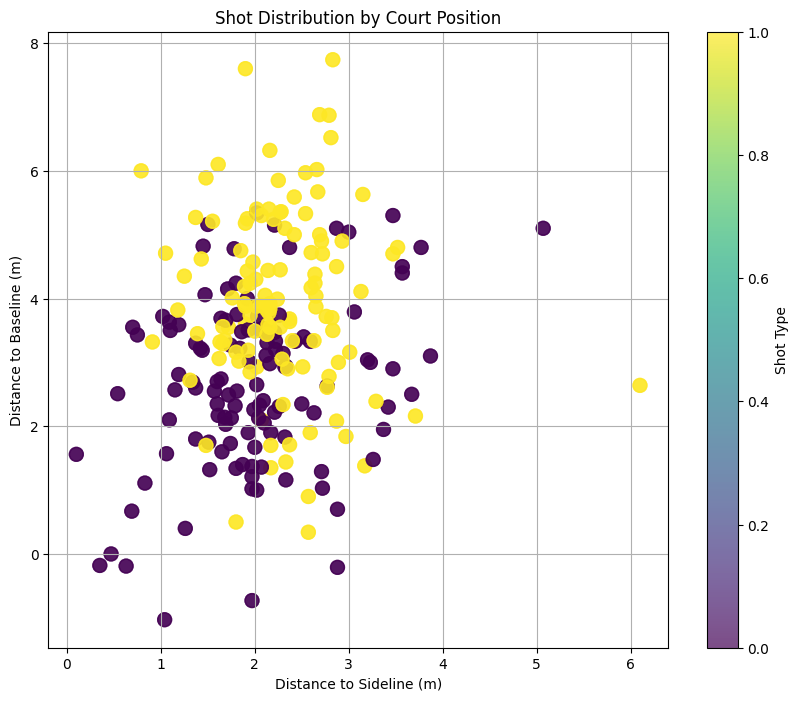

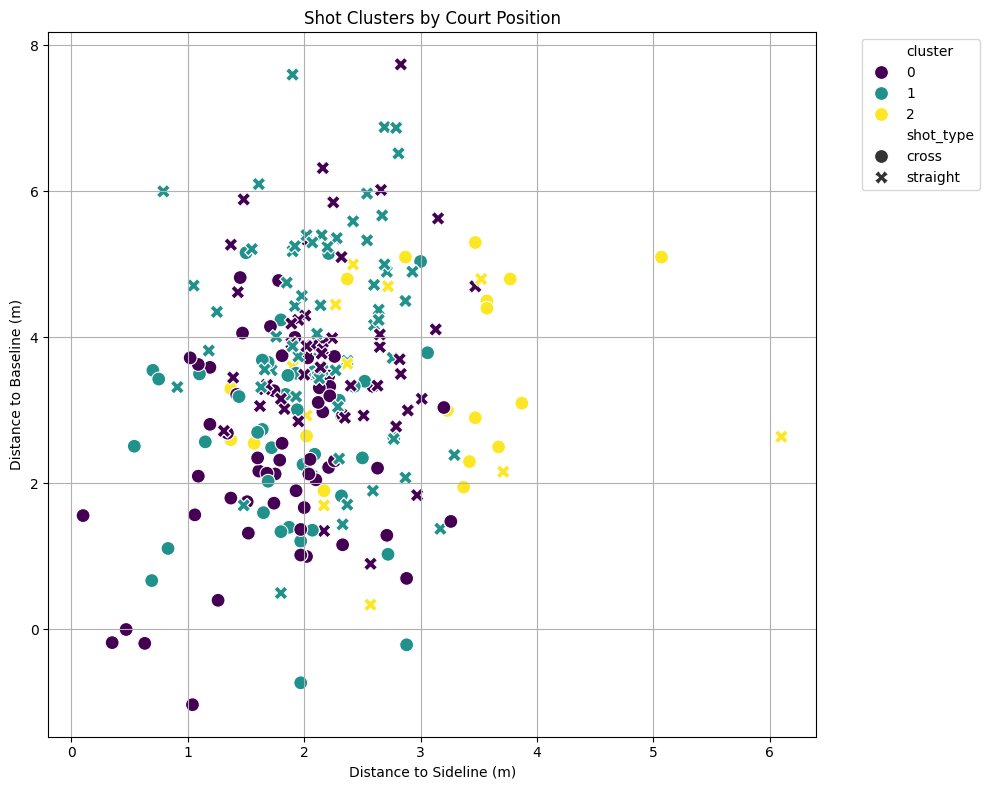

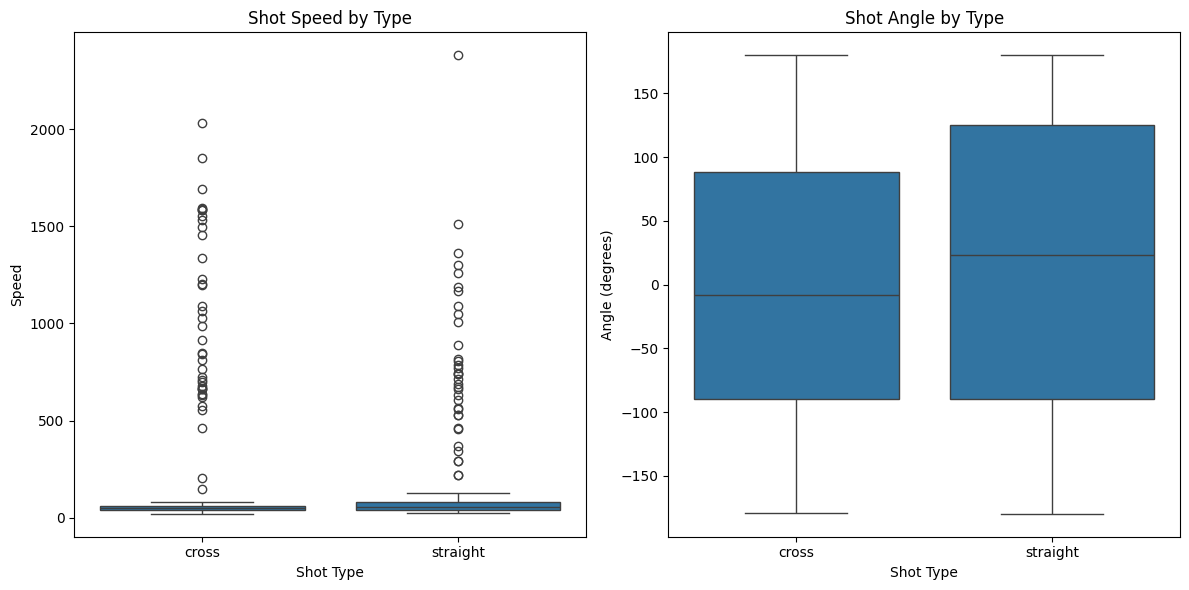

<Figure size 1000x600 with 0 Axes>

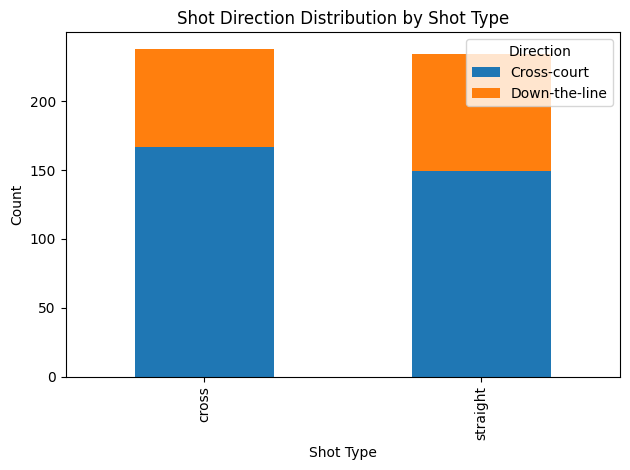

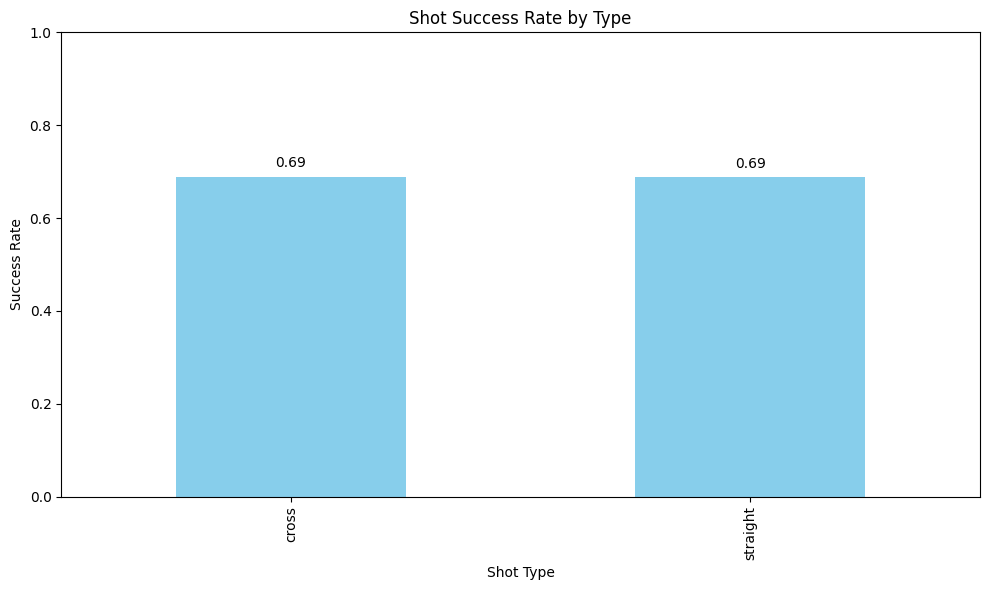

/var/folders/sb/2zyx_gr14m9cc4dd9p3l0d840000gp/T/ipykernel_85691/341569227.py:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_success = shot_df.groupby(['sideline_bin', 'baseline_bin'])['success'].mean().reset_index()


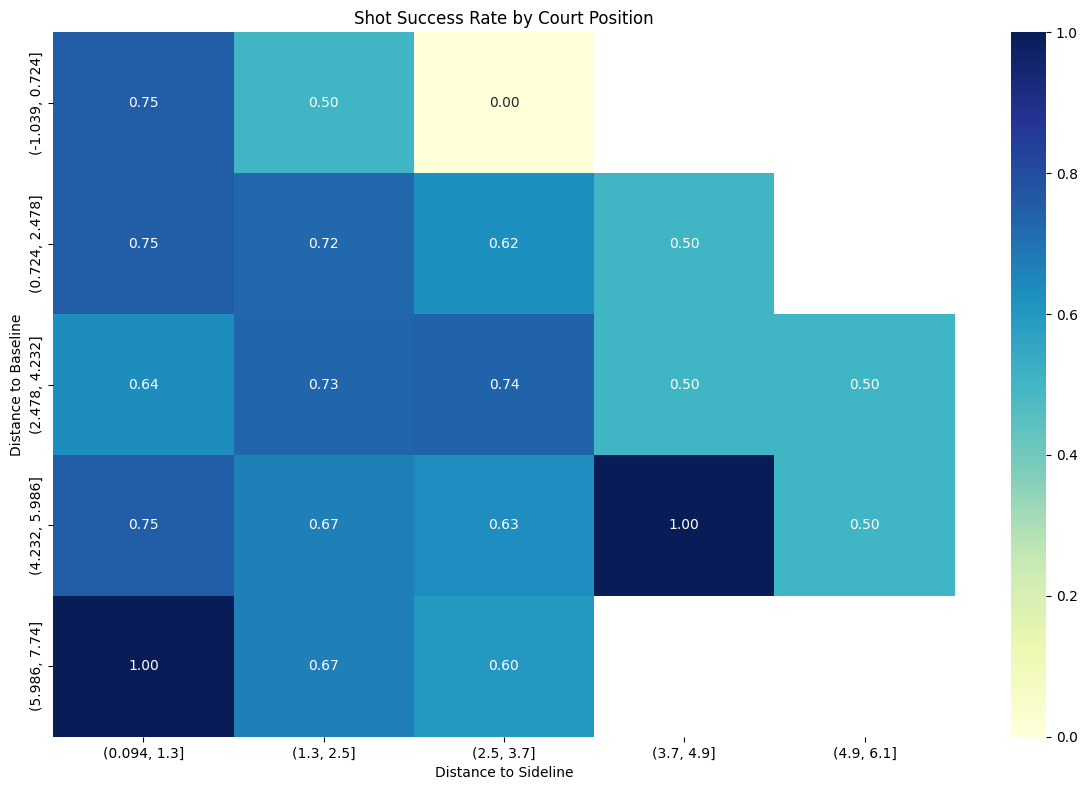

/var/folders/sb/2zyx_gr14m9cc4dd9p3l0d840000gp/T/ipykernel_85691/341569227.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_speed = shot_df.groupby('speed_bin')['success'].mean()
/var/folders/sb/2zyx_gr14m9cc4dd9p3l0d840000gp/T/ipykernel_85691/341569227.py:194: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_angle = shot_df.groupby('angle_bin')['success'].mean()


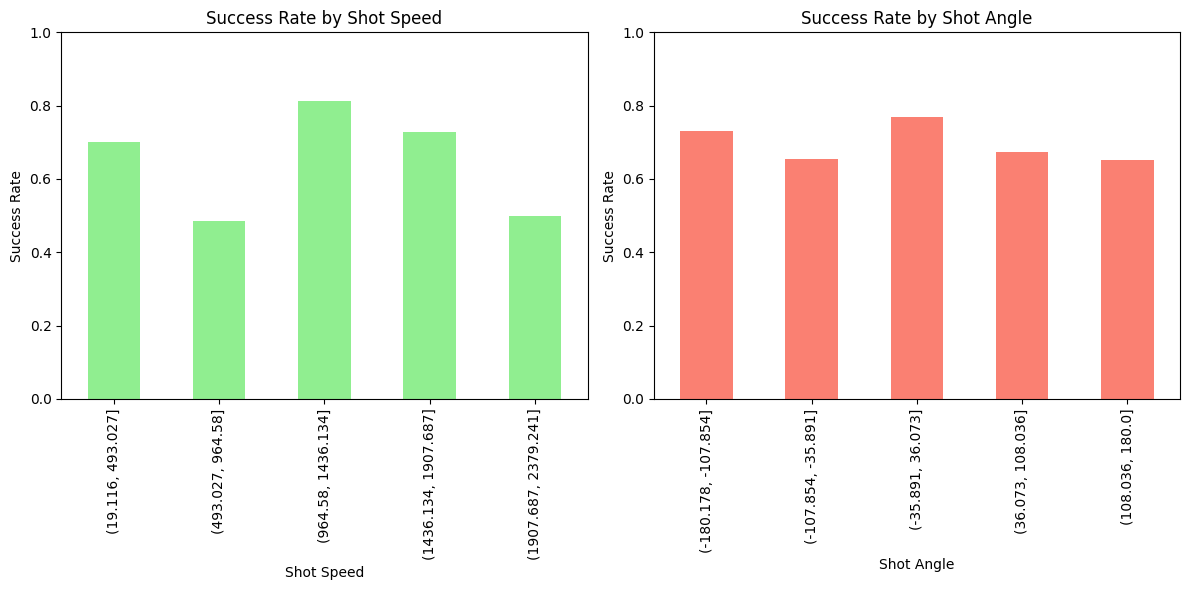

In [180]:
shot_df = create_shot_dataframe(shot_features)
shot_df_with_patterns = analyze_shot_patterns(shot_df)
shot_df_with_effectiveness = analyze_shot_effectiveness(shot_features)

In [181]:
# Function to visualize shot distribution on a tennis court
def visualize_shot_distribution(shot_df, player_id=None):
    # Filter by player if provided
    if player_id is not None:
        shot_df = shot_df[shot_df['player_id'] == player_id]
    
    # Create tennis court
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw court
    draw_tennis_court(ax)
    
    # Plot shots
    scatter = ax.scatter(
        shot_df['to_sideline_distance'],
        shot_df['to_baseline_distance'],
        c=shot_df['shot_type'].astype('category').cat.codes,
        s=100,
        alpha=0.7,
        cmap='viridis'
    )
    
    # Add legend
    legend_labels = shot_df['shot_type'].unique()
    legend = ax.legend(
        handles=scatter.legend_elements()[0],
        labels=legend_labels,
        title="Shot Types",
        loc="upper right"
    )
    
    # Set title and labels
    title = f"Shot Distribution for Player {player_id}" if player_id else "Shot Distribution for All Players"
    ax.set_title(title)
    ax.set_xlabel('Distance to Sideline (m)')
    ax.set_ylabel('Distance to Baseline (m)')
    
    plt.tight_layout()
    plt.show()

# Function to visualize success rates by shot type
def visualize_success_rates(shot_df, player_id=None):
    # Filter by player if provided
    if player_id is not None:
        shot_df = shot_df[shot_df['player_id'] == player_id]
    
    # Group by shot type and calculate success rate
    success_by_type = shot_df.groupby('shot_type')['success'].agg(['mean', 'count']).reset_index()
    success_by_type.columns = ['shot_type', 'success_rate', 'count']
    
    # Sort by count
    success_by_type = success_by_type.sort_values('count', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar plot
    bars = ax.bar(
        success_by_type['shot_type'],
        success_by_type['success_rate'],
        color='skyblue'
    )
    
    # Add count labels
    for i, (_, row) in enumerate(success_by_type.iterrows()):
        ax.text(
            i,
            row['success_rate'] + 0.02,
            f"n={int(row['count'])}",
            ha='center'
        )
    
    # Set title and labels
    title = f"Shot Success Rates for Player {player_id}" if player_id else "Shot Success Rates for All Players"
    ax.set_title(title)
    ax.set_xlabel('Shot Type')
    ax.set_ylabel('Success Rate')
    ax.set_ylim(0, 1)
    
    # Add horizontal grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Function to create a heatmap of shot distribution on the court
def visualize_shot_heatmap(shot_df, player_id=None, shot_type=None):
    # Filter by player and shot type if provided
    if player_id is not None:
        shot_df = shot_df[shot_df['player_id'] == player_id]
    if shot_type is not None:
        shot_df = shot_df[shot_df['shot_type'] == shot_type]
    
    # Create bins for court positions
    x_bins = np.linspace(0, 10, 20)  # Adjust based on your court dimensions
    y_bins = np.linspace(0, 10, 20)  # Adjust based on your court dimensions
    
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(
        shot_df['to_sideline_distance'],
        shot_df['to_baseline_distance'],
        bins=[x_bins, y_bins]
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw tennis court
    draw_tennis_court(ax)
    
    # Create heatmap
    heatmap = ax.imshow(
        h.T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        alpha=0.7
    )
    
    # Add colorbar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Shot Count')
    
    # Set title and labels
    title_parts = []
    if player_id is not None:
        title_parts.append(f"Player {player_id}")
    if shot_type is not None:
        title_parts.append(f"{shot_type} Shots")
    if not title_parts:
        title_parts.append("All Players and Shots")
    
    title = "Shot Heatmap for " + ", ".join(title_parts)
    ax.set_title(title)
    ax.set_xlabel('Distance to Sideline (m)')
    ax.set_ylabel('Distance to Baseline (m)')
    
    plt.tight_layout()
    plt.show()

# Function to draw a tennis court
def draw_tennis_court(ax):
    # Court dimensions (approximate)
    court_width = 10.97  # meters
    court_length = 23.77  # meters
    
    # Draw outer court
    court = Rectangle((0, 0), court_width, court_length, fill=False, color='black')
    ax.add_patch(court)
    
    # Draw net
    ax.plot([0, court_width], [court_length/2, court_length/2], 'k-', linewidth=2)
    
    # Draw service lines
    ax.plot([0, court_width], [court_length*0.25, court_length*0.25], 'k-', linewidth=1)
    ax.plot([0, court_width], [court_length*0.75, court_length*0.75], 'k-', linewidth=1)
    
    # Draw center service line
    ax.plot([court_width/2, court_width/2], [court_length*0.25, court_length*0.75], 'k-', linewidth=1)
    
    # Set limits
    ax.set_xlim(-1, court_width + 1)
    ax.set_ylim(-1, court_length + 1)
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')

# Main function to visualize shot statistics
def visualize_shot_distribution(shot_df, player_id=None):
    # Filter by player if provided
    if player_id is not None:
        # Check if player_id is array-like (e.g. list or np.ndarray)
        try:
            # Attempt to iterate over player_id; if it's a scalar, this will fail.
            iter(player_id)
            is_iterable = True
        except TypeError:
            is_iterable = False

        if is_iterable:
            shot_df = shot_df[shot_df['player_id'].isin(player_id)]
        else:
            shot_df = shot_df[shot_df['player_id'] == player_id]

    # Create tennis court
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw court
    draw_tennis_court(ax)
    
    # Plot shots with a categorical color mapping
    scatter = ax.scatter(
        shot_df['to_sideline_distance'],
        shot_df['to_baseline_distance'],
        c=shot_df['shot_type'].astype('category').cat.codes,
        s=100,
        alpha=0.7,
        cmap='viridis'
    )
    
    # Add legend
    legend_labels = list(shot_df['shot_type'].unique())
    legend_handles = list(scatter.legend_elements()[0])
    legend_labels = list(shot_df['shot_type'].unique())
    legend = ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        title="Shot Types",
        loc="upper right"
    )
    
    # Set title and labels
    title = f"Shot Distribution for Player {player_id}" if player_id is not None else "Shot Distribution for All Players"
    ax.set_title(title)
    ax.set_xlabel('Distance to Sideline (m)')
    ax.set_ylabel('Distance to Baseline (m)')
    
    plt.tight_layout()
    plt.show()

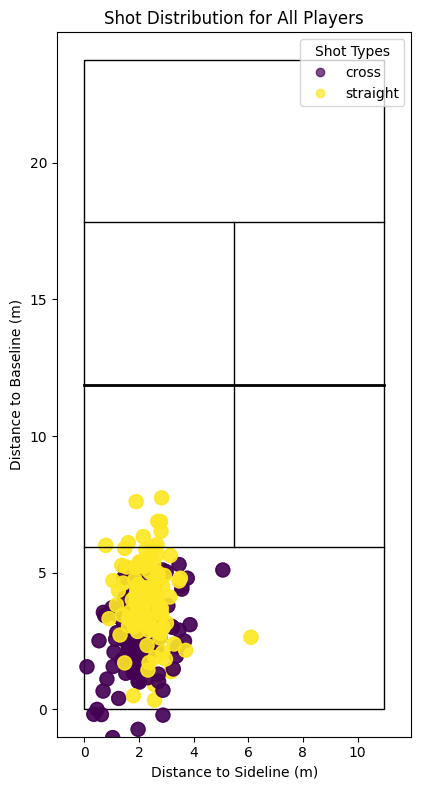

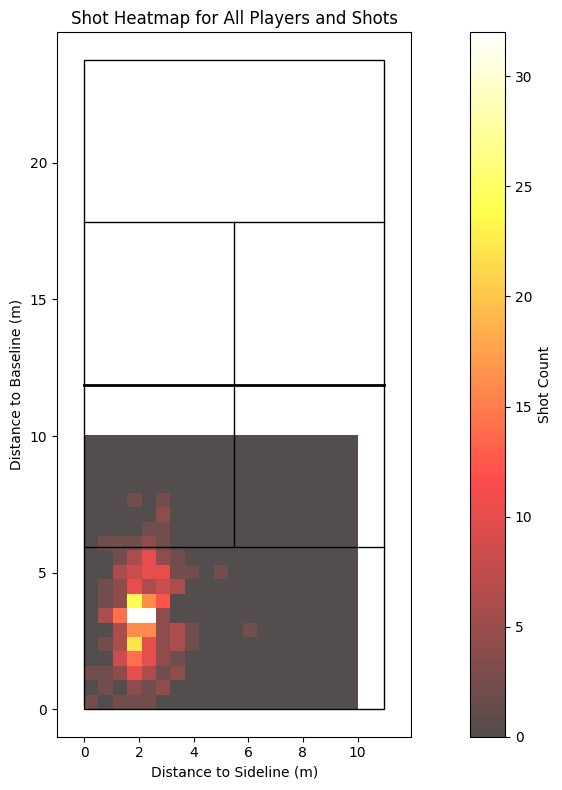

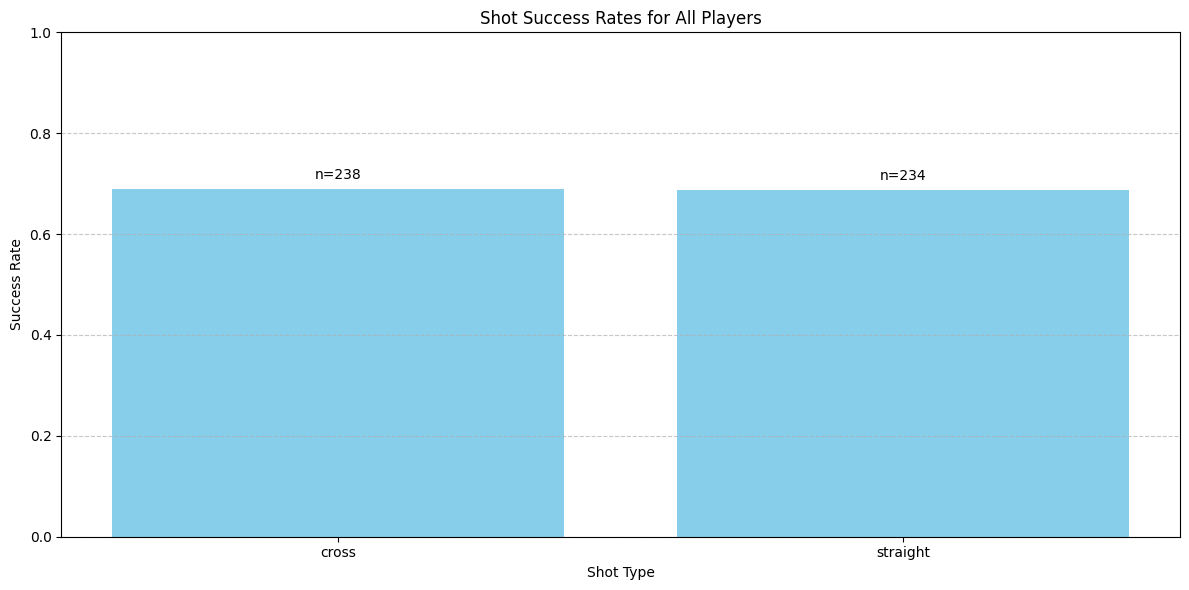

In [182]:
visualize_shot_distribution(shot_df)
visualize_shot_heatmap(shot_df_with_patterns)
visualize_success_rates(shot_df_with_effectiveness)

## 3. Player Movement and Positioning Analysis
Analyze player movements and court positioning to derive tactical insights.

a) Implement algorithms to analyze player movement patterns (e.g., speed, acceleration, distance covered).

b) Develop heatmaps to visualize player court coverage and preferred positions.

c) Identify correlations between player positioning and shot selection/effectiveness.

d) Analyze how player movements change in different game situations (e.g., serving, returning, baseline rallies).

Deliverables:
- Python code for movement and positioning analysis
- A comprehensive report (max 4 pages) describing your methodology, key findings, and potential tactical implications

#### a) Implement algorithms to analyze player movement patterns (e.g., speed, acceleration, distance covered).

Utility Functions to visualize all kinds of movement

In [183]:
# Plotting Helpers
# Central tennis court drawing function
def draw_tennis_court(ax, court_dimensions=None):
    """
    Draw a tennis court on the given matplotlib axis.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis to draw on
    court_dimensions (dict, optional): Dictionary with 'width' and 'length' keys in meters
    """
    # Default court dimensions in meters
    court_width = 10.97
    court_length = 23.77
    
    if court_dimensions is not None:
        court_width = court_dimensions.get('width', court_width)
        court_length = court_dimensions.get('length', court_length)
    
    # Draw outer court
    court = plt.Rectangle((0, 0), court_width, court_length, fill=False, color='black')
    ax.add_patch(court)
    
    # Draw net
    ax.plot([0, court_width], [court_length/2, court_length/2], 'k-', linewidth=2)
    
    # Draw service lines
    ax.plot([0, court_width], [court_length*0.25, court_length*0.25], 'k-', linewidth=1)
    ax.plot([0, court_width], [court_length*0.75, court_length*0.75], 'k-', linewidth=1)
    
    # Draw center service line
    ax.plot([court_width/2, court_width/2], [court_length*0.25, court_length*0.75], 'k-', linewidth=1)
    
    # Set limits with some padding
    ax.set_xlim(-1, court_width + 1)
    ax.set_ylim(-1, court_length + 1)
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')

# Consolidated plotting function for all heatmap types
def plot_court_heatmap(data, plot_type='position', court_dimensions=None, title=None, ax=None, colormap='hot', alpha=0.7):
    """
    Create a heatmap on a tennis court for different types of analyses.
    
    Parameters:
    data (list): List of position data dictionaries containing 'position_x', 'position_y', and other fields
    plot_type (str): Type of plot - 'position', 'speed', 'success', or 'shot_type'
    court_dimensions (dict, optional): Dictionary with 'width' and 'length' keys in meters
    title (str, optional): Plot title
    ax (matplotlib.axes.Axes, optional): The axis to draw on, if None a new one is created
    colormap (str): Matplotlib colormap name
    alpha (float): Transparency level for the plot
    
    Returns:
    fig (matplotlib.figure.Figure): The figure containing the plot
    ax (matplotlib.axes.Axes): The axis with the plot
    """
    if not data or len(data) < 2:
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
        else:
            fig = ax.figure
        
        draw_tennis_court(ax, court_dimensions)
        ax.set_title(f"{title or 'Tennis Court Analysis'} - Not enough data points")
        ax.set_xlabel('Court Width (m)')
        ax.set_ylabel('Court Length (m)')
        return fig, ax
    
    # Extract position data
    positions_x = [d.get('position_x', 0) for d in data]
    positions_y = [d.get('position_y', 0) for d in data]
    
    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.figure
    
    # Draw tennis court
    draw_tennis_court(ax, court_dimensions)
    
    # Different plot types
    if plot_type == 'position':
        # Position density heatmap using KDE
        try:
            heatmap = sns.kdeplot(
                x=positions_x,
                y=positions_y,
                cmap=colormap,
                fill=True,
                alpha=alpha,
                levels=20,
                thresh=0.05,
                ax=ax
            )
            
            # Add colorbar
            if heatmap.collections:
                cbar = fig.colorbar(heatmap.collections[0], ax=ax)
                cbar.set_label('Position Density')
            
            ax.set_title(title or 'Player Court Coverage')
            
        except Exception as e:
            print(f"KDE plot failed: {e}")
            # Fallback to scatter plot
            sc = ax.scatter(positions_x, positions_y, c='red', alpha=0.6, s=50)
            ax.set_title(f"{title or 'Player Court Coverage'} - Scatter Plot (KDE failed)")
    
    elif plot_type == 'speed':
        # Extract speed data
        speeds = [d.get('speed', 0) for d in data]
        
        # Create scatter plot with speed as color
        scatter = ax.scatter(
            positions_x,
            positions_y,
            c=speeds,
            cmap=colormap,
            s=50,
            alpha=alpha
        )
        
        # Add colorbar
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Speed (m/s)')
        
        ax.set_title(title or 'Player Speed Distribution')
    
    elif plot_type == 'success':
        # For position-success correlation plots
        success_values = [d.get('success', 0) for d in data]
        
        scatter = ax.scatter(
            positions_x,
            positions_y,
            c=success_values,
            cmap='RdYlGn',  # Red-Yellow-Green colormap
            s=80,
            alpha=alpha
        )
        
        # Add colorbar
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Success Rate')
        
        ax.set_title(title or 'Shot Success by Court Position')
    
    elif plot_type == 'shot_type':
        # Get unique shot types
        shot_types = set(d.get('shot_type', 'unknown') for d in data)
        shot_types = [st for st in shot_types if st != 'unknown']
        
        # Assign colors to shot types
        colors = plt.cm.tab10(np.linspace(0, 1, len(shot_types)))
        color_map = {shot_type: color for shot_type, color in zip(shot_types, colors)}
        
        # Plot each shot type separately
        for shot_type in shot_types:
            subset = [d for d in data if d.get('shot_type') == shot_type]
            if subset:
                subset_x = [d.get('position_x', 0) for d in subset]
                subset_y = [d.get('position_y', 0) for d in subset]
                
                ax.scatter(
                    subset_x,
                    subset_y,
                    c=[color_map[shot_type]] * len(subset),
                    label=shot_type,
                    s=80,
                    alpha=alpha
                )
        
        ax.legend(title="Shot Type")
        ax.set_title(title or 'Shot Type Distribution by Position')
    
    elif plot_type == 'cluster':
        # For position clusters
        clusters = [d.get('position_cluster', 0) for d in data]
        unique_clusters = set(clusters)
        
        # Assign colors to clusters
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
        
        # Plot each cluster
        for i, cluster in enumerate(unique_clusters):
            subset = [d for d in data if d.get('position_cluster') == cluster]
            if subset:
                subset_x = [d.get('position_x', 0) for d in subset]
                subset_y = [d.get('position_y', 0) for d in subset]
                
                ax.scatter(
                    subset_x,
                    subset_y,
                    c=[colors[i]] * len(subset),
                    label=f"Cluster {cluster}",
                    s=80,
                    alpha=alpha
                )
        
        ax.legend(title="Position Cluster")
        ax.set_title(title or 'Position Clusters')
    
    # Common settings
    ax.set_xlabel('Court Width (m)')
    ax.set_ylabel('Court Length (m)')
    
    return fig, ax


#### Create a visualization of player movement trajectory and speed profile.
    
**Parameters**:

- **movement_data** (list): List of player movement data points
- **court_dimensions** (dict, optional): Dictionary with 'width' and 'length' keys in meters
- **title** (str, optional): Main title for the plot
- **downsample_factor** (int): Factor to downsample trajectory points for cleaner visualization
- **figsize** (tuple): Figure size (width, height) in inches

**Returns**:
fig (matplotlib.figure.Figure): The figure containing the plots

In [184]:

# Function to plot player movement trajectory
def plot_movement_trajectory(movement_data, court_dimensions=None, title=None, downsample_factor=10, figsize=(16, 6)):
    if not movement_data or len(movement_data) < 2:
        fig, ax = plt.subplots(figsize=(12, 8))
        draw_tennis_court(ax, court_dimensions)
        ax.set_title(title or "Player Movement - Insufficient Data")
        ax.set_xlabel('Court Width (m)')
        ax.set_ylabel('Court Length (m)')
        return fig

    # Extract data
    positions_x = np.array([d.get('position_x', 0) for d in movement_data])
    positions_y = np.array([d.get('position_y', 0) for d in movement_data])
    speeds = np.array([d.get('speed', 0) for d in movement_data])
    
    # Ensure we have timestamps (or generate them)
    if 'timestamp' in movement_data[0]:
        timestamps = np.array([d.get('timestamp', 0) for d in movement_data])
    else:
        timestamps = np.arange(len(positions_x))

    # Downsample trajectory points for cleaner visualization
    if len(positions_x) > downsample_factor:
        sample_indices = np.linspace(0, len(positions_x) - 1, max(len(positions_x) // downsample_factor, 10), dtype=int)
        sampled_x = positions_x[sample_indices]
        sampled_y = positions_y[sample_indices]
        sampled_speeds = speeds[sample_indices]
        sampled_times = timestamps[sample_indices]
    else:
        sample_indices = np.arange(len(positions_x))
        sampled_x = positions_x
        sampled_y = positions_y
        sampled_speeds = speeds
        sampled_times = timestamps

    # Create figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    # Subplot 1: Movement Trajectory on court
    ax[0].set_title(title or "Player Movement Trajectory")
    draw_tennis_court(ax[0], court_dimensions)
    
    # Add trajectory path with gradient coloring by speed
    points = np.array([positions_x, positions_y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a colormap for speed
    norm = plt.Normalize(speeds.min(), speeds.max())
    lc = plt.matplotlib.collections.LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(speeds)
    lc.set_linewidth(2)
    line = ax[0].add_collection(lc)
    
    # Plot start and end points
    ax[0].scatter(positions_x[0], positions_y[0], color='green', s=150, marker='o', label='Start', zorder=5)
    ax[0].scatter(positions_x[-1], positions_y[-1], color='red', s=150, marker='o', label='End', zorder=5)
    
    # Add key points along the path
    scatter = ax[0].scatter(
        sampled_x, 
        sampled_y, 
        c=sampled_speeds, 
        cmap='viridis', 
        s=50, 
        edgecolors='black', 
        label="Key Movement Points"
    )
    
    ax[0].legend(loc='upper left')
    fig.colorbar(scatter, ax=ax[0], label="Speed (m/s)")

    # Subplot 2: Speed Profile
    ax[1].set_title("Speed Profile Over Time")
    ax[1].plot(timestamps, speeds, color='blue', alpha=0.7, linewidth=2, label="Speed")
    ax[1].scatter(sampled_times, sampled_speeds, color='red', s=50, label="Key Points")
    
    ax[1].set_xlabel("Time (seconds)" if 'timestamp' in movement_data[0] else "Frame Index")
    ax[1].set_ylabel("Speed (m/s)")
    ax[1].grid(True, linestyle='--', alpha=0.7)
    ax[1].legend()

    plt.tight_layout()
    return fig


#### Comparison Chart
Comparative visualizations for different metrics

In [185]:

def plot_comparison_chart(data, x_key, y_key, title=None, xlabel=None, ylabel=None, figsize=(10, 6), 
                         color='skyblue', count_key=None, plot_type='bar'):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Handle dictionary input (convert to lists)
    if isinstance(data, dict):
        if all(isinstance(v, dict) for v in data.values()):
            # Nested dictionary: {category: {metric1: value1, metric2: value2}}
            x_values = list(data.keys())
            y_values = [d.get(y_key, 0) for d in data.values()]
            
            if count_key:
                counts = [d.get(count_key, 0) for d in data.values()]
            else:
                counts = None
        else:
            # Simple dictionary: {key1: value1, key2: value2}
            x_values = list(data.keys())
            y_values = list(data.values())
            counts = None
    else:
        # List of dictionaries
        x_values = [item.get(x_key, 'Unknown') for item in data]
        y_values = [item.get(y_key, 0) for item in data]
        
        if count_key:
            counts = [item.get(count_key, 0) for item in data]
        else:
            counts = None
    
    # Create plot based on type
    if plot_type == 'bar':
        bars = ax.bar(x_values, y_values, color=color)
        
        # Add count labels if provided
        if counts:
            for i, (count, bar) in enumerate(zip(counts, bars)):
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_height() + max(y_values) * 0.03,
                    f"n={count}",
                    ha='center'
                )
    
    elif plot_type == 'line':
        ax.plot(x_values, y_values, marker='o', linestyle='-', color=color)
        
        # Add count labels if provided
        if counts:
            for i, (x, y, count) in enumerate(zip(x_values, y_values, counts)):
                ax.text(x, y + max(y_values) * 0.03, f"n={count}", ha='center')
    
    # Set labels and title
    ax.set_title(title or f"{y_key} by {x_key}")
    ax.set_xlabel(xlabel or x_key)
    ax.set_ylabel(ylabel or y_key)
    
    # Add grid for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust tick labels if needed
    if len(x_values) > 8:
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

# Function to create comparative positional visualizations
def plot_positional_comparison(data_groups, label_key, court_dimensions=None, title=None, figsize=(12, 8), 
                              show_counts=True, marker_scale=5):
    """
    Plot average positions of different groups/situations on the tennis court.
    
    Parameters:
    data_groups (dict): Dictionary mapping labels to lists of position data
    label_key (str): Key in the data that contains the group/label information
    court_dimensions (dict, optional): Dictionary with court dimensions
    title (str, optional): Plot title
    figsize (tuple): Figure size
    show_counts (bool): Whether to show counts as text labels
    marker_scale (int): Factor to scale marker size by count
    
    Returns:
    fig (matplotlib.figure.Figure): The figure containing the plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Draw tennis court
    draw_tennis_court(ax, court_dimensions)
    
    # Color map for different categories
    colors = plt.cm.tab10(np.linspace(0, 1, len(data_groups)))
    
    # Plot average position for each group
    for i, (label, group_data) in enumerate(data_groups.items()):
        if not group_data:
            continue
            
        # Extract position data
        positions_x = [d.get('position_x', 0) for d in group_data]
        positions_y = [d.get('position_y', 0) for d in group_data]
        
        # Calculate average position
        avg_x = np.mean(positions_x)
        avg_y = np.mean(positions_y)
        count = len(group_data)
        
        # Plot average position with size based on count
        ax.scatter(
            avg_x, 
            avg_y,
            s=count * marker_scale,
            color=colors[i],
            label=f"{label} (n={count})",
            alpha=0.8,
            edgecolors='black'
        )
        
        # Add text label if requested
        if show_counts:
            ax.annotate(
                f"{label}",
                (avg_x, avg_y),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
            )
    
    ax.set_title(title or f"Average Positions by {label_key}")
    ax.set_xlabel("Court Width (m)")
    ax.set_ylabel("Court Length (m)")
    ax.legend(title=label_key)
    
    plt.tight_layout()
    return fig


#### Final Analysis Panel
Multi-plot panel function for report generation
Create a comprehensive panel of plots for player movement analysis.
    
    Parameters:
    movement_data (list): List of player movement data points
    court_dimensions (dict, optional): Dictionary with court dimensions
    figsize (tuple): Figure size
    
    Returns:
    fig (matplotlib.figure.Figure): The figure containing all plots

In [186]:

# Multi-plot panel function for report generation
def create_analysis_panel(movement_data, court_dimensions=None, figsize=(18, 12)):
    if not movement_data or len(movement_data) < 2:
        fig, ax = plt.subplots(figsize=(12, 8))
        draw_tennis_court(ax, court_dimensions)
        ax.set_title("Player Movement Analysis - Insufficient Data")
        return fig
        
    # Create a 2x2 panel of plots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Court coverage heatmap (top left)
    plot_court_heatmap(movement_data, plot_type='position', court_dimensions=court_dimensions, 
                     title="Court Coverage", ax=axes[0, 0], colormap='Blues')
    
    # 2. Speed heatmap (top right)
    plot_court_heatmap(movement_data, plot_type='speed', court_dimensions=court_dimensions,
                     title="Speed Distribution", ax=axes[0, 1], colormap='viridis')
    
    # 3. Movement trajectory (bottom left)
    # Extract data
    positions_x = np.array([d.get('position_x', 0) for d in movement_data])
    positions_y = np.array([d.get('position_y', 0) for d in movement_data])
    speeds = np.array([d.get('speed', 0) for d in movement_data])
    
    # Draw tennis court
    draw_tennis_court(axes[1, 0], court_dimensions)
    
    # Add trajectory path with gradient coloring
    points = np.array([positions_x, positions_y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(speeds.min(), speeds.max())
    lc = plt.matplotlib.collections.LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(speeds)
    lc.set_linewidth(2)
    line = axes[1, 0].add_collection(lc)
    
    # Plot start and end points
    axes[1, 0].scatter(positions_x[0], positions_y[0], color='green', s=100, marker='o', label='Start')
    axes[1, 0].scatter(positions_x[-1], positions_y[-1], color='red', s=100, marker='o', label='End')
    axes[1, 0].legend(loc='upper left')
    axes[1, 0].set_title("Movement Trajectory")
    
    # 4. Speed profile (bottom right)
    if 'timestamp' in movement_data[0]:
        timestamps = [d.get('timestamp', 0) for d in movement_data]
        x_label = 'Time (seconds)'
    else:
        timestamps = range(len(movement_data))
        x_label = 'Frame Index'
        
    axes[1, 1].plot(timestamps, speeds, color='blue', linewidth=2)
    axes[1, 1].set_title("Speed Profile")
    axes[1, 1].set_xlabel(x_label)
    axes[1, 1].set_ylabel("Speed (m/s)")
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Add color bar for the trajectories
    cbar = fig.colorbar(line, ax=axes[1, 0])
    cbar.set_label('Speed (m/s)')
    
    plt.tight_layout()
    return fig

### Movement Analysis Functions
Utility Functions to analyze movement of the players

In [187]:
def load_multi_pose_model():
    # For single-pose detection
    model_path = kagglehub.model_download("google/movenet/tensorFlow2/singlepose-lightning")
    model = tf.saved_model.load(model_path)
    movenet_single = model.signatures['serving_default']
    
    # For multi-pose detection (needed for top view with multiple people)
    try:
        multipose_model_path = kagglehub.model_download("google/movenet/tensorFlow2/multipose-lightning")
        multipose_model = tf.saved_model.load(multipose_model_path)
        movenet_multi = multipose_model.signatures['serving_default']
    except:
        print("Warning: Could not load multipose model. Using single-pose model for all detections.")
        movenet_multi = movenet_single
    
    return movenet_multi

# Function to check if a point is on the tennis court
def is_on_court(point, court_params):
    # Court parameters should include court boundaries
    x, y = point
    court_left = court_params.get('left', 0)
    court_right = court_params.get('right', 1)
    court_top = court_params.get('top', 0)
    court_bottom = court_params.get('bottom', 1)
    
    return (court_left <= x <= court_right) and (court_top <= y <= court_bottom)

# Function to detect multiple people in a frame and identify the player
def detect_people(frame, pose_model, frame_index, court_params=None):
    # Prepare input frame
    input_image = tf.expand_dims(frame, axis=0)
    input_image = tf.image.resize_with_pad(input_image, 256, 256)
    input_image = tf.cast(input_image, dtype=tf.int32)
    
    # Run model inference
    outputs = pose_model(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))
    
    # For now, we'll focus on people with confidence above threshold
    people = []
    for person_idx, keypoints in enumerate(keypoints_with_scores):
        # Check if person detection is confident enough
        person_score = np.mean([keypoint[2] for keypoint in keypoints])
        if person_score > 0.3:  # Adjust threshold as needed
            # Extract keypoints with confidence scores
            person_data = {
                'keypoints': keypoints[:, :2],  # x, y coordinates
                'scores': keypoints[:, 2],  # confidence scores
                'person_id': person_idx,
                'frame_index': frame_index,
                'person_score': person_score
            }
            
            # Calculate center position of the person
            valid_keypoints = keypoints[keypoints[:, 2] > 0.3][:, :2]
            if len(valid_keypoints) > 0:
                center = np.mean(valid_keypoints, axis=0)
                person_data['center'] = center
                
                # If we have court parameters, check if person is on court
                if court_params is not None:
                    if is_on_court(center, court_params):
                        person_data['on_court'] = True
                    else:
                        person_data['on_court'] = False
                
                people.append(person_data)
    
    return people

# Function to identify the main player among detected people
def identify_main_player(people, previous_player=None, shot_info=None):
    if not people:
        return None
    
    # If we have previous player information, try to match with closest person
    if previous_player is not None:
        prev_center = previous_player.get('center')
        if prev_center is not None:
            min_dist = float('inf')
            closest_person = None
            
            for person in people:
                if 'center' in person:
                    dist = np.linalg.norm(person['center'] - prev_center)
                    if dist < min_dist:
                        min_dist = dist
                        closest_person = person
            
            # If distance is reasonable, assume it's the same player
            if min_dist < 0.3:  # Threshold for considering it's the same person
                return closest_person
    
    # If we have shot info, use that to identify player (e.g., player near baseline for serving)
    if shot_info is not None and 'shot_type' in shot_info:
        # For serving, player is likely near baseline
        if shot_info['shot_type'] == 'serve':
            # Find person closest to baseline
            baseline_y = 0.9  # Assuming normalized coordinates where baseline is at y=0.9
            min_dist = float('inf')
            closest_person = None
            
            for person in people:
                if 'center' in person:
                    dist = abs(person['center'][1] - baseline_y)
                    if dist < min_dist:
                        min_dist = dist
                        closest_person = person
            
            if closest_person is not None:
                return closest_person
    
    # Default: choose person with highest confidence score
    return max(people, key=lambda p: p['person_score']) if people else None


#### Movement Tracking across multiple frames

In [188]:

def track_player_movement(video_path, pose_model, court_params=None, shot_info=None):
    cap = cv2.VideoCapture(video_path)
    
    player_positions = []
    previous_player = None
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    sample_rate = 3  # Process every 3rd frame
    
    for frame_idx in range(0, frame_count, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Convert frame to RGB (TensorFlow models expect RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect people in the frame
        people = detect_people(frame_rgb, pose_model, frame_idx, court_params)
        
        # Identify main player
        player = identify_main_player(people, previous_player, shot_info)
        
        if player is not None:
            # Add timestamp
            player['timestamp'] = frame_idx / fps
            player_positions.append(player)
            previous_player = player
    
    cap.release()
    return player_positions

# Calculate movement metrics for the player
def calculate_movement_metrics(player_positions, court_dimensions=None):
    if not player_positions:
        return {}
    
    # Extract centers and timestamps
    centers = [p['center'] for p in player_positions if 'center' in p]
    timestamps = [p['timestamp'] for p in player_positions if 'timestamp' in p]
    
    if len(centers) < 2:
        return {'total_distance': 0, 'avg_speed': 0, 'max_speed': 0, 'acceleration': []}
    
    # Convert to numpy arrays
    centers = np.array(centers)
    timestamps = np.array(timestamps)
    
    # If we have court dimensions, convert positions to real-world coordinates (meters)
    if court_dimensions is not None:
        court_width = court_dimensions.get('width', 10.97)  # in meters
        court_length = court_dimensions.get('length', 23.77)  # in meters
        
        # Assuming normalized coordinates (0-1), scale to real-world dimensions
        centers[:, 0] *= court_width
        centers[:, 1] *= court_length
    
    # Calculate distances between consecutive positions
    diffs = np.diff(centers, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    
    # Calculate time differences
    time_diffs = np.diff(timestamps)
    
    # Calculate speed (distance/time)
    speeds = distances / time_diffs
    
    # Calculate acceleration
    acceleration = np.diff(speeds) / time_diffs[:-1] if len(speeds) > 1 else []
    
    # Smooth the speed values using Savitzky-Golay filter if enough points
    if len(speeds) > 10:
        window_length = min(11, len(speeds) - (len(speeds) % 2) - 1)  # Ensure odd window length
        if window_length > 2:
            speeds_smoothed = savgol_filter(speeds, window_length, 2)
        else:
            speeds_smoothed = speeds
    else:
        speeds_smoothed = speeds
    
    # Calculate total distance, average and max speed
    total_distance = np.sum(distances)
    avg_speed = np.mean(speeds_smoothed)
    max_speed = np.max(speeds_smoothed)
    
    # Prepare movement data for each frame
    movement_data = []
    for i in range(len(centers)-1):
        data_point = {
            'position_x': centers[i][0],
            'position_y': centers[i][1],
            'timestamp': timestamps[i],
            'speed': speeds_smoothed[i] if i < len(speeds_smoothed) else 0,
        }
        
        # Add acceleration if available
        if i < len(acceleration):
            data_point['acceleration'] = acceleration[i]
        
        movement_data.append(data_point)
    
    # Add final position
    if centers.shape[0] > 0:
        movement_data.append({
            'position_x': centers[-1][0],
            'position_y': centers[-1][1],
            'timestamp': timestamps[-1],
            'speed': 0,  # Final position has no speed
            'acceleration': 0  # Final position has no acceleration
        })
    
    return {
        'total_distance': total_distance,
        'avg_speed': avg_speed,
        'max_speed': max_speed,
        'movement_data': movement_data
    }

# Correlate player positions with shot effectiveness
def analyze_position_shot_correlation(movement_data, shot_data):
    # Merge movement data with shot data based on timestamps
    merged_data = []
    
    for shot in shot_data:
        # Find movement data closest to shot timestamp
        shot_time = shot.get('timestamp', 0)
        closest_movement = min(movement_data, key=lambda m: abs(m.get('timestamp', 0) - shot_time))
        
        merged_point = {
            'position_x': closest_movement.get('position_x', 0),
            'position_y': closest_movement.get('position_y', 0),
            'shot_type': shot.get('shot_type', 'unknown'),
            'success': shot.get('success', 0),
            'speed': closest_movement.get('speed', 0),
            'to_sideline_distance': shot.get('to_sideline_distance', 0),
            'to_baseline_distance': shot.get('to_baseline_distance', 0)
        }
        
        merged_data.append(merged_point)
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(merged_data)
    
    # Create position clusters using KMeans
    if len(df) > 5:  # Need enough data points for clustering
        position_data = df[['position_x', 'position_y']].values
        kmeans = KMeans(n_clusters=min(5, len(df)), random_state=42)
        df['position_cluster'] = kmeans.fit_predict(position_data)
        
        # Calculate success rate by position cluster
        success_by_cluster = df.groupby('position_cluster')['success'].agg(['mean', 'count']).reset_index()
        success_by_cluster.columns = ['position_cluster', 'success_rate', 'count']
        
        # Calculate shot type distribution by position cluster
        shot_type_by_cluster = df.groupby(['position_cluster', 'shot_type']).size().unstack(fill_value=0)
        
        return {
            'merged_data': df.to_dict('records'),  # Convert back to list of dicts for plotting
            'success_by_cluster': success_by_cluster.to_dict('records'),
            'shot_type_by_cluster': shot_type_by_cluster.reset_index().to_dict('records')
        }
    else:
        return {
            'merged_data': merged_data,
            'success_by_cluster': None,
            'shot_type_by_cluster': None
        }

# Analyze player movement in different game situations
def analyze_situational_movement(movement_data, shot_data):
    # Categorize shots by situation
    situations = {
        'serving': [],
        'returning': [],
        'baseline_rally': [],
        'net_play': []
    }
    
    # Merge movement and shot data
    merged_data = []
    
    for shot in shot_data:
        # Determine situation based on shot type and position
        shot_type = shot.get('shot_type', 'unknown')
        baseline_distance = shot.get('to_baseline_distance', 0)
        
        # Find movement data closest to shot timestamp
        shot_time = shot.get('timestamp', 0)
        closest_movement = min(movement_data, key=lambda m: abs(m.get('timestamp', 0) - shot_time))
        
        # Combine shot and movement data
        combined = {**shot, **closest_movement}
        
        # Categorize by situation
        if shot_type == 'serve':
            situation = 'serving'
        elif shot_type == 'return':
            situation = 'returning'
        elif baseline_distance < 3:  # Close to net
            situation = 'net_play'
        else:
            situation = 'baseline_rally'
        
        combined['situation'] = situation
        situations[situation].append(combined)
        merged_data.append(combined)
    
    # Calculate movement metrics for each situation
    situation_metrics = {}
    for situation, data in situations.items():
        if len(data) > 0:
            position_x = [d.get('position_x', 0) for d in data]
            position_y = [d.get('position_y', 0) for d in data]
            speeds = [d.get('speed', 0) for d in data]
            
            metrics = {
                'avg_position_x': np.mean(position_x),
                'avg_position_y': np.mean(position_y),
                'avg_speed': np.mean(speeds),
                'count': len(data)
            }
            
            situation_metrics[situation] = metrics
    
    return {
        'merged_data': merged_data,
        'situation_metrics': situation_metrics,
        'situations': situations
    }


#### Identification algorithm for the main player across multiple frames

In [189]:

def identify_main_player_in_sequence(all_people_tracks, video_info):
    if not all_people_tracks:
        return []
    
    # Get information about expected ball landing position
    to_sideline_distance = video_info.get('to_sideline_distance', None)
    to_baseline_distance = video_info.get('to_baseline_distance', None)
    
    # Convert court dimensions to pixel coordinates (approximate)
    court_width = video_info.get('width', 1920)
    court_height = video_info.get('height', 1080)
    
    # Assuming the court is centered in the image and takes up most of the frame
    expected_x = None
    expected_y = None
    
    if to_sideline_distance is not None and to_baseline_distance is not None:
        # Convert distances to approximate pixel coordinates
        # This would need calibration for exact values
        expected_x = court_width * (to_sideline_distance / 10.97)  # 10.97m is standard tennis court width
        expected_y = court_height * (to_baseline_distance / 23.77)  # 23.77m is standard tennis court length
    
    # For each frame, calculate the likelihood of each person being the main player
    person_scores = {}  # Track accumulated scores for each person ID
    
    for frame_data in all_people_tracks:
        people = frame_data.get('people', [])
        
        for person in people:
            person_id = person.get('person_id')
            
            if person_id not in person_scores:
                person_scores[person_id] = 0
            
            # Increase score based on various factors
            
            # 1. Higher detection confidence means more likely to be a player
            person_scores[person_id] += person.get('person_score', 0) * 5
            
            # 2. If we know expected position, closer to it means more likely to be the player
            if expected_x is not None and expected_y is not None and 'center' in person:
                dist_to_expected = np.sqrt(
                    (person['center'][0] - expected_x)**2 + 
                    (person['center'][1] - expected_y)**2
                )
                # Inverse distance (closer = higher score)
                proximity_score = 1000 / (dist_to_expected + 10)  # +10 to avoid division by zero
                person_scores[person_id] += proximity_score
            
            # 3. If person is on court, more likely to be player
            if person.get('on_court', False):
                person_scores[person_id] += 10
    
    # Identify the person with the highest score
    if person_scores:
        main_player_id = max(person_scores, key=person_scores.get)
        
        # Extract the main player's track
        main_player_track = []
        
        for frame_data in all_people_tracks:
            timestamp = frame_data.get('timestamp')
            
            # Find the main player in this frame
            main_player = None
            for person in frame_data.get('people', []):
                if person.get('person_id') == main_player_id:
                    main_player = person
                    break
            
            # If main player is found in this frame, add to track
            if main_player is not None:
                # Add timestamp if not already present
                if 'timestamp' not in main_player:
                    main_player['timestamp'] = timestamp
                
                main_player_track.append(main_player)
        
        return main_player_track
    
    # If no scores were accumulated, return empty track
    return []

# Process top-view specific data
def analyze_top_view_movement(video_info, pose_model):
    video_path = video_info['path']
    
    # Check if it's a top-view video
    if 'view_type' in video_info and video_info['view_type'].lower() == 'top':
        print(f"Processing top-view video: {video_path}")
        
        # Special processing for top-view
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        # For top view, we need to track multiple people and identify the main player
        all_people_tracks = []
        sample_rate = 3  # Process every 3rd frame for efficiency
        
        for frame_idx in range(0, frame_count, sample_rate):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if not ret:
                break
            
            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Detect people in the frame
            people = detect_people(frame_rgb, pose_model, frame_idx)
            
            # Add timestamp to each person
            timestamp = frame_idx / fps
            for person in people:
                person['timestamp'] = timestamp
            
            all_people_tracks.append({
                'frame_idx': frame_idx,
                'timestamp': timestamp,
                'people': people
            })
        
        cap.release()
        
        # Now we need to identify which detections correspond to the main player
        main_player_track = identify_main_player_in_sequence(all_people_tracks, video_info)
        
        return main_player_track
    else:
        # For side-view, use the regular tracking function
        return track_player_movement(video_path, pose_model)


#### Player movement analysis with consolidated plotting.
    
    Parameters:
    video_data (list): List of dictionaries with video information
    shot_data (list, optional): List of dictionaries with shot information
    output_dir (str): Directory to save output files
    
    Returns:
    dict: Results of the analysis

In [190]:

def analyze_player_movement_consolidated(video_data, shot_data=None, output_dir='./output'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    results = {}
    
    # 1. Load pose estimation model
    pose_model = load_multi_pose_model()
    
    # Process each video
    for video_info in video_data:
        video_path = video_info['path']
        video_id = video_info.get('index', 0)
        
        print(f"Processing video: {video_path}")
        
        # Check view type and process accordingly
        view_type = video_info.get('view_type', 'side').lower()
        
        if view_type == 'top':
            # Use specialized top-view processing
            player_positions = analyze_top_view_movement(video_info, pose_model)
        else:
            # Use standard processing for side view
            court_params = {
                'left': 0,
                'right': video_info.get('width', 1920),
                'top': 0,
                'bottom': video_info.get('height', 1080)
            }
            
            # Convert to normalized coordinates
            for key in court_params:
                if key in ['left', 'right']:
                    court_params[key] /= video_info.get('width', 1920)
                else:
                    court_params[key] /= video_info.get('height', 1080)
            
            player_positions = track_player_movement(
                video_path,
                pose_model,
                court_params=court_params,
                shot_info=video_info
            )
        
        # Define court dimensions (in meters)
        court_dimensions = {
            'width': 10.97,  # standard tennis court width
            'length': 23.77  # standard tennis court length
        }
        
        # Calculate movement metrics
        movement_metrics = calculate_movement_metrics(player_positions, court_dimensions)
        movement_data = movement_metrics.get('movement_data', [])
        
        # Initialize plots dictionary
        plots = {}
        
        # 1. Create comprehensive analysis panel (combines multiple plots)
        analysis_panel = create_analysis_panel(movement_data, court_dimensions)
        panel_filename = f"video_{video_id}_analysis_panel.png"
        analysis_panel.savefig(os.path.join(output_dir, panel_filename))
        plots['analysis_panel'] = panel_filename
        plt.close(analysis_panel)
        
        # 2. Create court coverage heatmap
        if len(movement_data) >= 2:
            fig, ax = plot_court_heatmap(movement_data, plot_type='position', 
                                     court_dimensions=court_dimensions,
                                     title=f"Video {video_id} - Player Court Coverage")
            coverage_filename = f"video_{video_id}_court_coverage.png"
            fig.savefig(os.path.join(output_dir, coverage_filename))
            plots['court_coverage'] = coverage_filename
            plt.close(fig)
        
        # 3. Process shot data if available
        position_shot_correlation = None
        situational_analysis = None
        
        if shot_data is not None:
            # Filter shot data for this video
            video_shot_data = [s for s in shot_data if s.get('video_id', 0) == video_id]
            
            if video_shot_data:
                # Analyze position-shot correlation
                position_shot_correlation = analyze_position_shot_correlation(movement_data, video_shot_data)
                
                # Create shot success heatmap
                if position_shot_correlation and position_shot_correlation['merged_data']:
                    fig, ax = plot_court_heatmap(
                        position_shot_correlation['merged_data'], 
                        plot_type='success',
                        court_dimensions=court_dimensions,
                        title=f"Video {video_id} - Shot Success by Position"
                    )
                    success_filename = f"video_{video_id}_shot_success.png"
                    fig.savefig(os.path.join(output_dir, success_filename))
                    plots['shot_success'] = success_filename
                    plt.close(fig)
                    
                    # Create shot type distribution map
                    fig, ax = plot_court_heatmap(
                        position_shot_correlation['merged_data'], 
                        plot_type='shot_type',
                        court_dimensions=court_dimensions,
                        title=f"Video {video_id} - Shot Types by Position"
                    )
                    shottype_filename = f"video_{video_id}_shot_types.png"
                    fig.savefig(os.path.join(output_dir, shottype_filename))
                    plots['shot_types'] = shottype_filename
                    plt.close(fig)
                
                # Analyze situational movement
                situational_analysis = analyze_situational_movement(movement_data, video_shot_data)
                
                if situational_analysis and situational_analysis['merged_data']:
                    # Create situation comparison chart
                    situation_metrics = situational_analysis['situation_metrics']
                    if situation_metrics:
                        # Average speed by situation
                        fig = plot_comparison_chart(
                            situation_metrics, 
                            x_key='situation', 
                            y_key='avg_speed',
                            title=f"Video {video_id} - Average Speed by Situation",
                            xlabel="Game Situation",
                            ylabel="Average Speed (m/s)",
                            count_key='count'
                        )
                        speed_filename = f"video_{video_id}_situation_speeds.png"
                        fig.savefig(os.path.join(output_dir, speed_filename))
                        plots['situation_speeds'] = speed_filename
                        plt.close(fig)
                        
                        # Average position by situation
                        fig = plot_positional_comparison(
                            situational_analysis['situations'],
                            label_key='Situation',
                            court_dimensions=court_dimensions,
                            title=f"Video {video_id} - Average Position by Situation"
                        )
                        position_filename = f"video_{video_id}_situation_positions.png"
                        fig.savefig(os.path.join(output_dir, position_filename))
                        plots['situation_positions'] = position_filename
                        plt.close(fig)
        
        # 4. Create detailed movement trajectory
        if len(movement_data) >= 2:
            fig = plot_movement_trajectory(
                movement_data, 
                court_dimensions=court_dimensions,
                title=f"Video {video_id} - Player Movement Trajectory"
            )
            trajectory_filename = f"video_{video_id}_trajectory.png"
            fig.savefig(os.path.join(output_dir, trajectory_filename))
            plots['trajectory'] = trajectory_filename
            plt.close(fig)
            
        # Store results for this video
        results[video_id] = {
            'movement_metrics': {
                'total_distance': movement_metrics.get('total_distance', 0),
                'avg_speed': movement_metrics.get('avg_speed', 0),
                'max_speed': movement_metrics.get('max_speed', 0)
            },
            'player_positions': player_positions,
            'movement_data': movement_data,
            'view_type': view_type,
            'plots': plots,
            'position_shot_correlation': position_shot_correlation,
            'situational_movement': situational_analysis
        }    
    return {'results': results}

### Main Analysis Function

In [191]:
# Run comprehensive analysis
analysis_results = analyze_player_movement_consolidated(video_data, shot_features)
# Since there are too many images, We have dumped them into an output Directory.
# However we have picked random 3 images of each type and plotting just for visualization purposes

Processing video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT16.mp4
Processing top-view video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT16.mp4
Processing video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT02.mp4
Processing top-view video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT02.mp4
Processing video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT03.mp4
Processing top-view video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT03.mp4
Processing video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT17.mp4
Processing top-view video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT17.mp4
Processing video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT01.mp4
Processing top-view video: tennis_player_dataset/Outdoor Field/Cross-court Shot/Top-View/OCT01.mp4
Processing video: tennis_player_dataset/Outdoor Field/C

#### Visualizing 9 analysis results for getting a raw idea on analysis

Found 99 analysis panel files, 99 court coverage files, and 99 trajectory files.


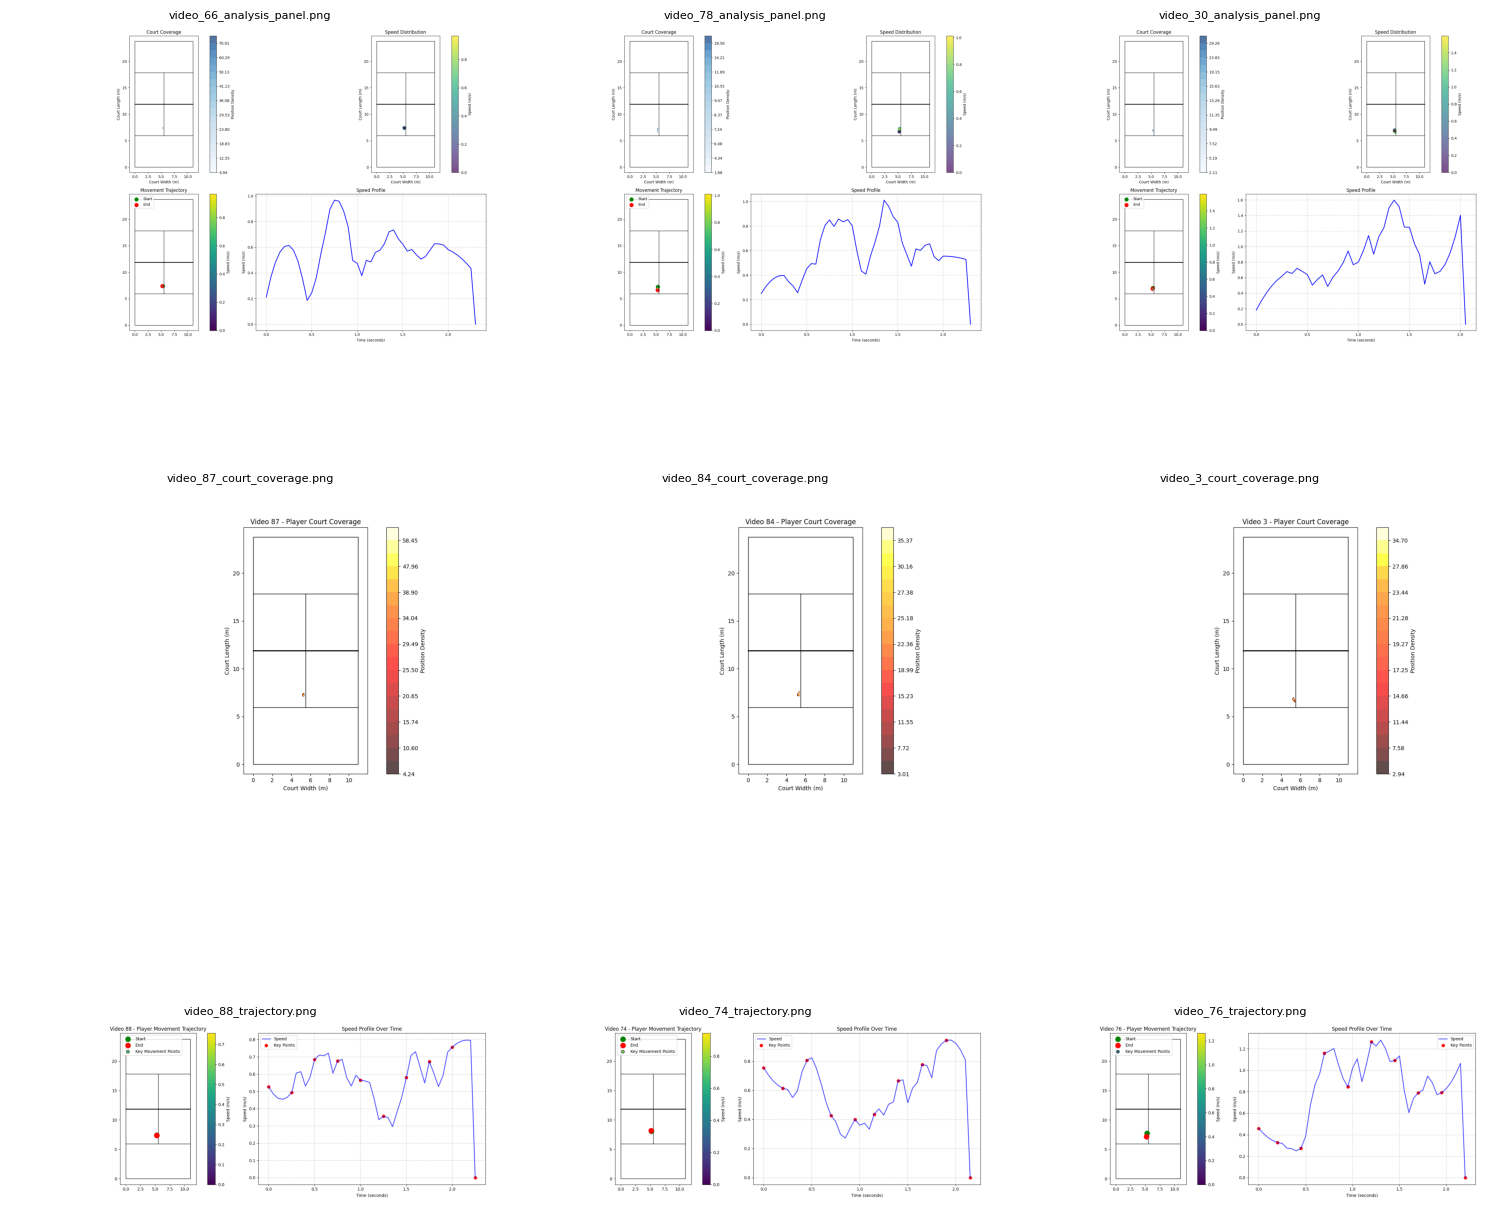

In [192]:
def visualize_random_9_images_by_pattern(output_dir='./output'):
    """
    Scans the output directory for PNG images that match three categories:
      - analysis_panel
      - court_coverage
      - trajectory
    Randomly selects 3 images from each category and displays them in a 3x3 grid.
    """
    # List all files in the output directory
    all_files = os.listdir(output_dir)
    # Filter for .png files
    png_files = [f for f in all_files if f.endswith('.png')]
    
    # Build full paths and filter based on filename patterns
    analysis_panel_files = [os.path.join(output_dir, f) for f in png_files if 'analysis_panel' in f]
    court_coverage_files = [os.path.join(output_dir, f) for f in png_files if 'court_coverage' in f]
    trajectory_files = [os.path.join(output_dir, f) for f in png_files if 'trajectory' in f]
    
    # Debug: print out how many files we found for each category
    print(f"Found {len(analysis_panel_files)} analysis panel files, {len(court_coverage_files)} court coverage files, and {len(trajectory_files)} trajectory files.")
    
    # Randomly sample 3 files from each category (or as many as available)
    sample_analysis = random.sample(analysis_panel_files, min(3, len(analysis_panel_files)))
    sample_coverage = random.sample(court_coverage_files, min(3, len(court_coverage_files)))
    sample_trajectory = random.sample(trajectory_files, min(3, len(trajectory_files)))
    
    # Combine the samples; ideally we have 9 images
    selected_images = sample_analysis + sample_coverage + sample_trajectory
    
    # If fewer than 9 images, pad with None
    while len(selected_images) < 9:
        selected_images.append(None)
    
    # Create a 3x3 subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        image_path = selected_images[i]
        if image_path is not None:
            try:
                image = plt.imread(image_path)
                ax.imshow(image)
                ax.set_title(os.path.basename(image_path), fontsize=8)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
        else:
            ax.text(0.5, 0.5, 'No image available', ha='center', va='center')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
visualize_random_9_images_by_pattern(output_dir='./output')

### 4. Match Strategy and Performance Metrics
Integrate the above components to develop high-level match strategy analysis and performance metrics.

a) Develop a system to automatically extract key performance indicators (e.g., winners, unforced errors, serve efficiency).

b) Implement algorithms to identify critical points and analyze player performance under pressure.

c) Create visualizations that summarize match dynamics and player strategies.

d) Propose and implement a novel metric or analysis technique that provides unique insights into tennis performance or strategy.

Deliverables:
- Python code for the integrated analysis system
- A set of visualizations demonstrating your system's capabilities
- A final report (max 5 pages) summarizing the entire project, including a discussion of strategic insights and potential applications for players and coaches



#### Assumption for Success Metrics 
Since there's no success metric, We're generating shot based success and failure metrics and then later on use those metrics for doing above classifications.
- These metrics are generated based on shot distance on double sideline and base line.
- In some cases additional random factor is also used to tweak success metric

##### Generate synthetic success data based on court position
    
    Parameters:
    - video_data: List of dictionaries containing video information
    
    Returns:
    - Enhanced video_data with success estimates

In [193]:
# Function to generate synthetic success data based on court position
def generate_success_data(video_data):
    enhanced_data = []
    
    # Define "sweet spots" on the court - positions that typically yield higher success
    # These are based on tennis strategy: being close to baseline for groundstrokes
    # and closer to net for volleys
    sweet_spots = [
        {'to_sideline_distance': 3.0, 'to_baseline_distance': 1.0, 'radius': 2.0},  # Baseline corner
        {'to_sideline_distance': 5.5, 'to_baseline_distance': 1.0, 'radius': 2.0},  # Baseline center
        {'to_sideline_distance': 5.5, 'to_baseline_distance': 7.0, 'radius': 1.5},  # Net center
    ]
    
    for video in video_data:
        video_copy = video.copy()
        
        # Calculate distance to nearest sweet spot
        min_distance = float('inf')
        for spot in sweet_spots:
            distance = sqrt(
                (video['to_sideline_distance'] - spot['to_sideline_distance'])**2 +
                (video['to_baseline_distance'] - spot['to_baseline_distance'])**2
            )
            normalized_distance = distance / spot['radius']
            min_distance = min(min_distance, normalized_distance)
        
        # Convert distance to success probability (closer = higher success)
        # Add some randomness for realism
        base_probability = max(0, min(1, 1 - (min_distance * 0.25)))
        random_factor = np.random.normal(0, 0.1)  # Mean 0, std 0.1
        success_probability = max(0, min(1, base_probability + random_factor))
        
        # Determine binary success (1 = success, 0 = failure)
        success = 1 if np.random.random() < success_probability else 0
        
        # Add to video data
        video_copy['success'] = success
        video_copy['success_probability'] = success_probability
        
        # Also add shot type based on position
        if video['to_baseline_distance'] < 2.0:
            # Near baseline - likely a groundstroke
            if video['to_sideline_distance'] < 3.0 or video['to_sideline_distance'] > 8.0:
                shot_type = 'backhand'
            else:
                shot_type = 'forehand'
        elif video['to_baseline_distance'] > 7.0:
            # Near net - likely a volley
            shot_type = 'volley'
        else:
            # Middle of court - could be various shots
            if video['environment'] == 'outdoor' and video['shot_type'] == 'cross':
                shot_type = 'backhand'
            else:
                shot_type = 'forehand'
        
        video_copy['shot_type'] = shot_type
        
        enhanced_data.append(video_copy)
    
    return enhanced_data


##### Analyze shot distribution by court position
    
    Parameters:
    - video_data: List of dictionaries containing video information with success estimates
    
    Returns:
    - Dictionary of analysis results

In [194]:

# Function to perform basic court position analysis
def analyze_court_positions(video_data):
    # Convert to DataFrame
    df = pd.DataFrame(video_data)
    
    # Calculate basic position-based metrics
    position_metrics = {
        'avg_sideline_distance': df['to_sideline_distance'].mean(),
        'avg_baseline_distance': df['to_baseline_distance'].mean(),
        'total_shots': len(df),
        'success_rate': df['success'].mean() if 'success' in df.columns else None
    }
    
    # Cluster positions to identify patterns
    if len(df) >= 5:  # Need at least 5 data points for meaningful clustering
        # Prepare position data
        positions = df[['to_sideline_distance', 'to_baseline_distance']].values
        
        # Determine optimal number of clusters (between 2 and 5)
        max_clusters = min(5, len(df) - 1)
        inertias = []
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(positions)
            inertias.append(kmeans.inertia_)
        
        # Find elbow point
        if len(inertias) > 1:
            k_opt = 2  # Default
            max_curvature = 0
            for i in range(1, len(inertias) - 1):
                # Calculate curvature using angle between consecutive segments
                a = np.array([i-1, inertias[i-1]])
                b = np.array([i, inertias[i]])
                c = np.array([i+1, inertias[i+1]])
                
                ab = b - a
                bc = c - b
                
                # Normalize
                ab = ab / np.linalg.norm(ab)
                bc = bc / np.linalg.norm(bc)
                
                # Calculate angle
                curvature = np.abs(np.arccos(np.dot(ab, bc)))
                
                if curvature > max_curvature:
                    max_curvature = curvature
                    k_opt = i + 2  # +2 because i starts at 1 and we add 1 for original range
        else:
            k_opt = 2
        
        # Cluster with optimal k
        kmeans = KMeans(n_clusters=k_opt, random_state=42)
        df['position_cluster'] = kmeans.fit_predict(positions)
        
        # Calculate success rate by cluster
        cluster_stats = df.groupby('position_cluster').agg({
            'to_sideline_distance': 'mean',
            'to_baseline_distance': 'mean',
            'success': 'mean' if 'success' in df.columns else None,
            'shot_type': lambda x: x.value_counts().index[0]
        }).reset_index()
        
        position_metrics['position_clusters'] = cluster_stats.to_dict('records')
    
    # Calculate shot type distribution
    if 'shot_type' in df.columns:
        shot_counts = df['shot_type'].value_counts().to_dict()
        position_metrics['shot_type_distribution'] = shot_counts
    
    # Success rate by environment
    if 'success' in df.columns and 'environment' in df.columns:
        success_by_env = df.groupby('environment')['success'].mean().to_dict()
        position_metrics['success_by_environment'] = success_by_env
    
    # Success rate by shot type
    if 'success' in df.columns and 'shot_type' in df.columns:
        success_by_shot = df.groupby('shot_type')['success'].mean().to_dict()
        position_metrics['success_by_shot_type'] = success_by_shot
    
    return position_metrics

# Function to visualize court position analysis
def visualize_court_positions(video_data, court_dimensions=None):
    """
    Create visualizations of shot distribution by court position
    
    Parameters:
    - video_data: List of dictionaries containing video information with success estimates
    - court_dimensions: Optional dictionary with court dimensions
    
    Returns:
    - Dictionary of matplotlib figures
    """
    # Convert to DataFrame
    df = pd.DataFrame(video_data)
    figures = {}
    
    # 1. Shot Distribution by Court Position
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Draw tennis court
    draw_tennis_court(ax, court_dimensions)
    
    # Create scatter plot colored by success
    if 'success' in df.columns:
        scatter = ax.scatter(
            df['to_sideline_distance'], 
            df['to_baseline_distance'], 
            c=df['success'],
            cmap='RdYlGn',
            alpha=0.7,
            s=100
        )
        
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Shot Success')
        
        ax.set_title('Shot Success by Court Position')
    else:
        # Color by shot type if success not available
        if 'shot_type' in df.columns:
            shot_types = df['shot_type'].unique()
            for shot_type in shot_types:
                subset = df[df['shot_type'] == shot_type]
                ax.scatter(
                    subset['to_sideline_distance'],
                    subset['to_baseline_distance'],
                    label=shot_type,
                    alpha=0.7,
                    s=100
                )
            ax.legend(title='Shot Type')
            ax.set_title('Shot Type Distribution by Court Position')
        else:
            # Simple position plot
            ax.scatter(df['to_sideline_distance'], df['to_baseline_distance'], alpha=0.7, s=100)
            ax.set_title('Shot Distribution by Court Position')
    
    ax.set_xlabel('Distance to Sideline (m)')
    ax.set_ylabel('Distance to Baseline (m)')
    
    figures['shot_distribution'] = fig
    
    # 2. Position Heatmap
    if len(df) >= 5:  # Need enough points for a meaningful heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Draw tennis court
        draw_tennis_court(ax, court_dimensions)
        
        try:
            # Create heatmap using KDE
            sns.kdeplot(
                x=df['to_sideline_distance'],
                y=df['to_baseline_distance'],
                cmap='hot',
                fill=True,
                alpha=0.7,
                ax=ax
            )
            
            ax.set_title('Shot Density Heatmap')
            ax.set_xlabel('Distance to Sideline (m)')
            ax.set_ylabel('Distance to Baseline (m)')
            
            figures['position_heatmap'] = fig
        except Exception as e:
            print(f"Error creating position heatmap: {e}")
    
    # 3. Success Rate by Shot Type (if available)
    if 'success' in df.columns and 'shot_type' in df.columns:
        success_by_shot = df.groupby('shot_type')['success'].agg(['mean', 'count']).reset_index()
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        bars = ax.bar(
            success_by_shot['shot_type'],
            success_by_shot['mean'] * 100,  # Convert to percentage
            color='skyblue'
        )
        
        # Add count labels
        for i, bar in enumerate(bars):
            count = success_by_shot.iloc[i]['count']
            ax.text(
                bar.get_x() + bar.get_width()/2, 
                bar.get_height() + 2, 
                f'n={count}',
                ha='center'
            )
        
        ax.set_ylim(0, 100)
        ax.set_ylabel('Success Rate (%)')
        ax.set_title('Shot Success Rate by Type')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        figures['success_by_shot_type'] = fig
    
    # 4. Environment Comparison (if available)
    if 'environment' in df.columns:
        env_counts = df['environment'].value_counts()
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        ax.pie(
            env_counts,
            labels=env_counts.index,
            autopct='%1.1f%%',
            startangle=90
        )
        
        ax.axis('equal')
        ax.set_title('Shot Distribution by Environment')
        
        figures['environment_distribution'] = fig
        
        # Add success by environment if available
        if 'success' in df.columns:
            success_by_env = df.groupby('environment')['success'].agg(['mean', 'count']).reset_index()
            
            fig, ax = plt.subplots(figsize=(8, 6))
            
            bars = ax.bar(
                success_by_env['environment'],
                success_by_env['mean'] * 100,  # Convert to percentage
                color='lightgreen'
            )
            
            # Add count labels
            for i, bar in enumerate(bars):
                count = success_by_env.iloc[i]['count']
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + 2, 
                    f'n={count}',
                    ha='center'
                )
            
            ax.set_ylim(0, 100)
            ax.set_ylabel('Success Rate (%)')
            ax.set_title('Shot Success Rate by Environment')
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            
            figures['success_by_environment'] = fig
    
    return figures


#### Added Visualisations
Here we have covered added visualisations based on different frames

Function: **generate_position_insights**

Generate strategic insights from court position analysis
    
    Parameters:
    - position_metrics: Dictionary containing position analysis results
    
    Returns:
    - List of insight dictionaries

In [195]:

# Draw tennis court for visualization
def draw_tennis_court(ax, court_dimensions=None):
    # Default court dimensions in meters
    court_width = 10.97
    court_length = 23.77
    
    if court_dimensions is not None:
        court_width = court_dimensions.get('width', court_width)
        court_length = court_dimensions.get('length', court_length)
    
    # Draw outer court
    court = Rectangle((0, 0), court_width, court_length, fill=False, color='black')
    ax.add_patch(court)
    
    # Draw net
    ax.plot([0, court_width], [court_length/2, court_length/2], 'k-', linewidth=2)
    
    # Draw service lines
    ax.plot([0, court_width], [court_length*0.25, court_length*0.25], 'k-', linewidth=1)
    ax.plot([0, court_width], [court_length*0.75, court_length*0.75], 'k-', linewidth=1)
    
    # Draw center service line
    ax.plot([court_width/2, court_width/2], [court_length*0.25, court_length*0.75], 'k-', linewidth=1)
    
    # Set limits
    ax.set_xlim(-1, court_width + 1)
    ax.set_ylim(-1, court_length + 1)
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')

# Generate strategic insights based on court position analysis
def generate_position_insights(position_metrics):
    insights = []
    
    # 1. Overall Court Position Insights
    avg_baseline = position_metrics.get('avg_baseline_distance')
    if avg_baseline is not None:
        if avg_baseline < 2.0:
            insights.append({
                "category": "Court Positioning",
                "insight": "Baseline-dominant play",
                "description": "Player tends to stay close to the baseline, which may limit opportunities for aggressive net play."
            })
        elif avg_baseline > 5.0:
            insights.append({
                "category": "Court Positioning",
                "insight": "Net-approaching tendency",
                "description": "Player frequently approaches the net, showing an aggressive tactical approach."
            })
    
    # 2. Shot Type Distribution Insights
    shot_dist = position_metrics.get('shot_type_distribution', {})
    if shot_dist:
        total_shots = sum(shot_dist.values())
        
        # Check for dominant shot types
        for shot_type, count in shot_dist.items():
            percentage = count / total_shots
            if percentage > 0.7:
                insights.append({
                    "category": "Shot Selection",
                    "insight": f"Over-reliance on {shot_type} shots",
                    "description": f"Player uses {shot_type} shots for {percentage:.1%} of all shots, which may make play predictable."
                })
    
    # 3. Success Rate Insights
    success_by_shot = position_metrics.get('success_by_shot_type', {})
    if success_by_shot:
        # Find strongest and weakest shots
        if len(success_by_shot) > 1:
            strongest_shot = max(success_by_shot.items(), key=lambda x: x[1])
            weakest_shot = min(success_by_shot.items(), key=lambda x: x[1])
            
            insights.append({
                "category": "Shot Effectiveness",
                "insight": f"Strongest shot: {strongest_shot[0]}",
                "description": f"Player achieves {strongest_shot[1]:.1%} success rate with {strongest_shot[0]} shots."
            })
            
            if weakest_shot[1] < 0.4:  # Only highlight if clearly a weakness
                insights.append({
                    "category": "Areas for Improvement",
                    "insight": f"Weakness in {weakest_shot[0]} shots",
                    "description": f"Player achieves only {weakest_shot[1]:.1%} success rate with {weakest_shot[0]} shots, suggesting room for improvement."
                })
    
    # 4. Environment Insights
    success_by_env = position_metrics.get('success_by_environment', {})
    if success_by_env and len(success_by_env) > 1:
        # Compare indoor vs outdoor performance
        if 'indoor' in success_by_env and 'outdoor' in success_by_env:
            diff = success_by_env['indoor'] - success_by_env['outdoor']
            if abs(diff) > 0.15:  # Significant difference
                better_env = 'indoor' if diff > 0 else 'outdoor'
                insights.append({
                    "category": "Environment Preference",
                    "insight": f"Better performance in {better_env} conditions",
                    "description": f"Player performs {abs(diff):.1%} better in {better_env} conditions compared to {'outdoor' if better_env == 'indoor' else 'indoor'}."
                })
    
    # 5. Position Cluster Insights
    clusters = position_metrics.get('position_clusters', [])
    if clusters:
        # Find highest success cluster
        if 'success' in clusters[0]:
            best_cluster = max(clusters, key=lambda x: x['success'])
            
            insights.append({
                "category": "Optimal Court Positioning",
                "insight": "Identified optimal court position",
                "description": f"Player achieves highest success ({best_cluster['success']:.1%}) when positioned around {best_cluster['to_sideline_distance']:.1f}m from sideline and {best_cluster['to_baseline_distance']:.1f}m from baseline."
            })
    
    return insights


#### Comprehensive Dashboard
We have created a comprehensive dashboard of strategic insights based on court position
    
    Parameters:
    - position_metrics: Dictionary containing position analysis results
    - visualizations: Dictionary of matplotlib figures
    - player_name: Name of the player for labeling
    - output_path: Optional path to save the dashboard
    
    Returns:
    - Figure of the dashboard

In [196]:

# Create a strategic insights dashboard
def create_position_dashboard(position_metrics, visualizations, player_name="Player", output_path=None):
    # Generate insights
    insights = generate_position_insights(position_metrics)
    
    # Create dashboard figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))
    
    # Define the grid layout
    gs = gridspec.GridSpec(3, 6, figure=fig)
    
    # 1. Header with player name and key metrics
    ax_header = fig.add_subplot(gs[0, :])
    ax_header.axis('off')
    
    header_text = f"{player_name} - Court Position Analysis Dashboard"
    ax_header.text(0.5, 0.6, header_text, fontsize=24, ha='center', va='center', fontweight='bold')
    
    # Add key metrics below the header
    metrics_text = ""
    metrics_text += f"Total Shots: {position_metrics.get('total_shots', 'N/A')} | "
    metrics_text += f"Success Rate: {position_metrics.get('success_rate', 0):.1%} | "
    metrics_text += f"Avg. Distance to Baseline: {position_metrics.get('avg_baseline_distance', 0):.1f}m | "
    metrics_text += f"Avg. Distance to Sideline: {position_metrics.get('avg_sideline_distance', 0):.1f}m"
    
    ax_header.text(0.5, 0.2, metrics_text, fontsize=14, ha='center', va='center')
    
    # 2. Shot Distribution Visualization
    if 'shot_distribution' in visualizations:
        ax_dist = fig.add_subplot(gs[1:3, 0:2])
        # Copy content from the figure to the dashboard
        shot_dist_fig = visualizations['shot_distribution']
        shot_dist_ax = shot_dist_fig.axes[0]
        
        # Draw the court
        draw_tennis_court(ax_dist)
        
        # Copy scatter points
        for collection in shot_dist_ax.collections:
            offsets = collection.get_offsets()
            # Optionally get sizes, colors, etc.
            sizes = collection.get_sizes()
            facecolors = collection.get_facecolors()
            edgecolors = collection.get_edgecolors()
            
            # Recreate the scatter plot on the new axes
            ax_dist.scatter(
                offsets[:, 0],
                offsets[:, 1],
                s=sizes,
                c=facecolors if facecolors.size else None,
                edgecolors=edgecolors if edgecolors.size else None
            )
        
        ax_dist.set_title(shot_dist_ax.get_title())
        ax_dist.set_xlabel(shot_dist_ax.get_xlabel())
        ax_dist.set_ylabel(shot_dist_ax.get_ylabel())
    
    # 3. Position Heatmap
    if 'position_heatmap' in visualizations:
        ax_heat = fig.add_subplot(gs[1, 2:4])
        # Copy content from the figure to the dashboard
        heat_fig = visualizations['position_heatmap']
        heat_ax = heat_fig.axes[0]
        
        # Draw the court
        draw_tennis_court(ax_heat)
        
        for collection in heat_ax.collections:
            if hasattr(collection, 'get_paths'):
                # Extract vertices from each path
                segments = []
                for path in collection.get_paths():
                    if hasattr(path, 'vertices') and len(path.vertices) > 1:
                        # Only add the vertices array, not the Path object itself
                        segments.append(path.vertices)
                
                if segments:  # Make sure there are segments to copy
                    lc = LineCollection(segments, 
                                    colors=collection.get_edgecolors(),
                                    linewidths=collection.get_linewidths(),
                                    linestyles=collection.get_linestyles(),
                                    alpha=collection.get_alpha())
                    ax_heat.add_collection(lc)
    
    # 4. Success by Shot Type
    if 'success_by_shot_type' in visualizations:
        ax_shot = fig.add_subplot(gs[1, 4:6])
        # Copy content from the figure to the dashboard
        shot_fig = visualizations['success_by_shot_type']
        shot_ax = shot_fig.axes[0]
        
        # Copy bar chart
        for patch in shot_ax.patches:
            ax_shot.bar(
                patch.get_x() + patch.get_width()/2,
                patch.get_height(),
                width=patch.get_width(),
                color=patch.get_facecolor()
            )
        
        # Copy text annotations
        for text in shot_ax.texts:
            ax_shot.text(
                text.get_position()[0],
                text.get_position()[1],
                text.get_text(),
                ha=text.get_ha(),
                va=text.get_va()
            )
        
        ax_shot.set_ylim(0, 100)
        ax_shot.set_ylabel(shot_ax.get_ylabel())
        ax_shot.set_title(shot_ax.get_title())
        ax_shot.set_xticks(shot_ax.get_xticks())
        ax_shot.set_xticklabels(shot_ax.get_xticklabels())
        ax_shot.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 5. Environment Comparison
    if 'success_by_environment' in visualizations:
        ax_env = fig.add_subplot(gs[2, 2:4])
        # Copy content from the figure to the dashboard
        env_fig = visualizations['success_by_environment']
        env_ax = env_fig.axes[0]
        
        # Copy bar chart
        for patch in env_ax.patches:
            ax_env.bar(
                patch.get_x() + patch.get_width()/2,
                patch.get_height(),
                width=patch.get_width(),
                color=patch.get_facecolor()
            )
        
        # Copy text annotations
        for text in env_ax.texts:
            ax_env.text(
                text.get_position()[0],
                text.get_position()[1],
                text.get_text(),
                ha=text.get_ha(),
                va=text.get_va()
            )
        
        ax_env.set_ylim(0, 100)
        ax_env.set_ylabel(env_ax.get_ylabel())
        ax_env.set_title(env_ax.get_title())
        ax_env.set_xticks(env_ax.get_xticks())
        ax_env.set_xticklabels(env_ax.get_xticklabels())
        ax_env.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 6. Strategic Insights Panel
    if insights:
        # Group insights by category
        
        categories = defaultdict(list)
        for insight in insights:
            categories[insight['category']].append(insight)
        
        # Create text for insights panel
        insights_text = "STRATEGIC INSIGHTS:\n\n"
        
        for category, category_insights in categories.items():
            insights_text += f"{category}:\n"
            for i, insight in enumerate(category_insights, 1):
                insights_text += f"  {i}. {insight['insight']}\n"
            insights_text += "\n"
        
        # Add insights text to the dashboard
        ax_insights = fig.add_subplot(gs[2, 4:6])
        ax_insights.axis('off')
        ax_insights.text(0.05, 0.95, insights_text, fontsize=12, va='top', linespacing=1.5)
    
    plt.tight_layout()
    
    # Save if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    
    return fig

### Main Execution Function to Execute Analysis
Run the complete tennis position analysis pipeline
    
    Parameters:
    - video_data: List of dictionaries containing video information
    - player_name: Name of the player for labeling
    - output_dir: Directory to save output files
    
    Returns:
    - Dictionary containing analysis results and visualizations

Starting tennis position analysis for Tennis Player...
Generating synthetic success estimates...
Analyzing court positions...
Creating visualizations...
Creating position analysis dashboard...
Analysis complete. Dashboard saved to: ./perf/Tennis Player_position_dashboard_20250305_124208.png
Analysis report saved to: ./perf/Tennis Player_position_analysis_20250305_124208.txt


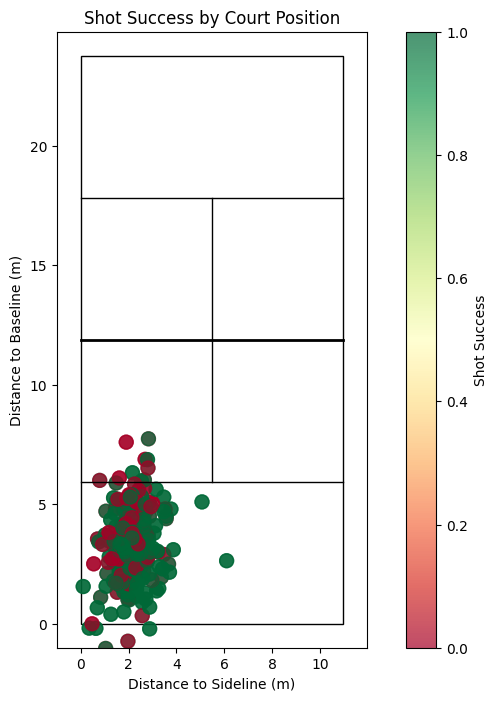

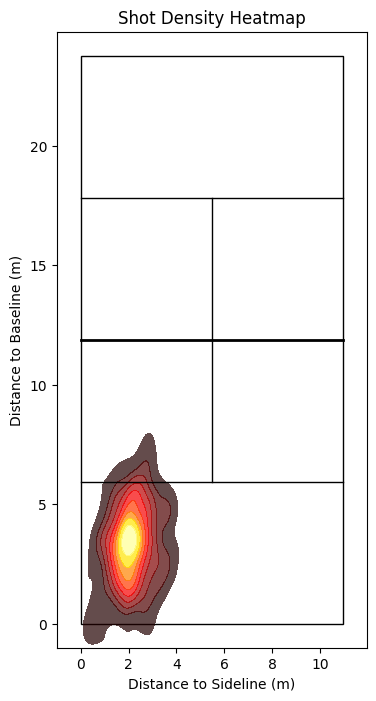

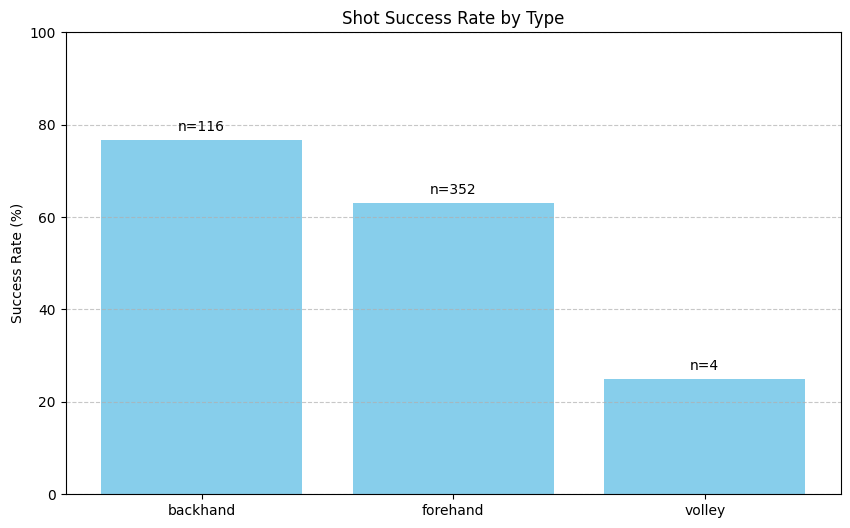

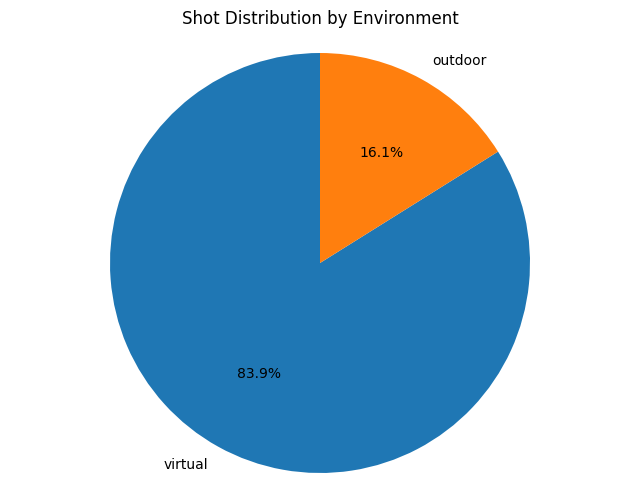

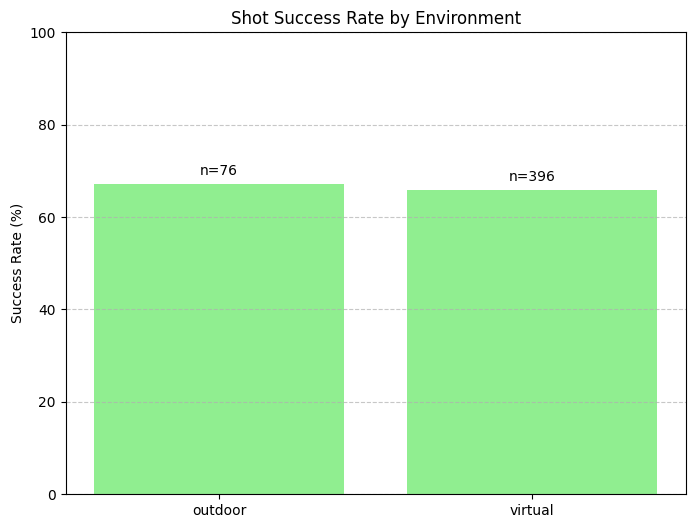

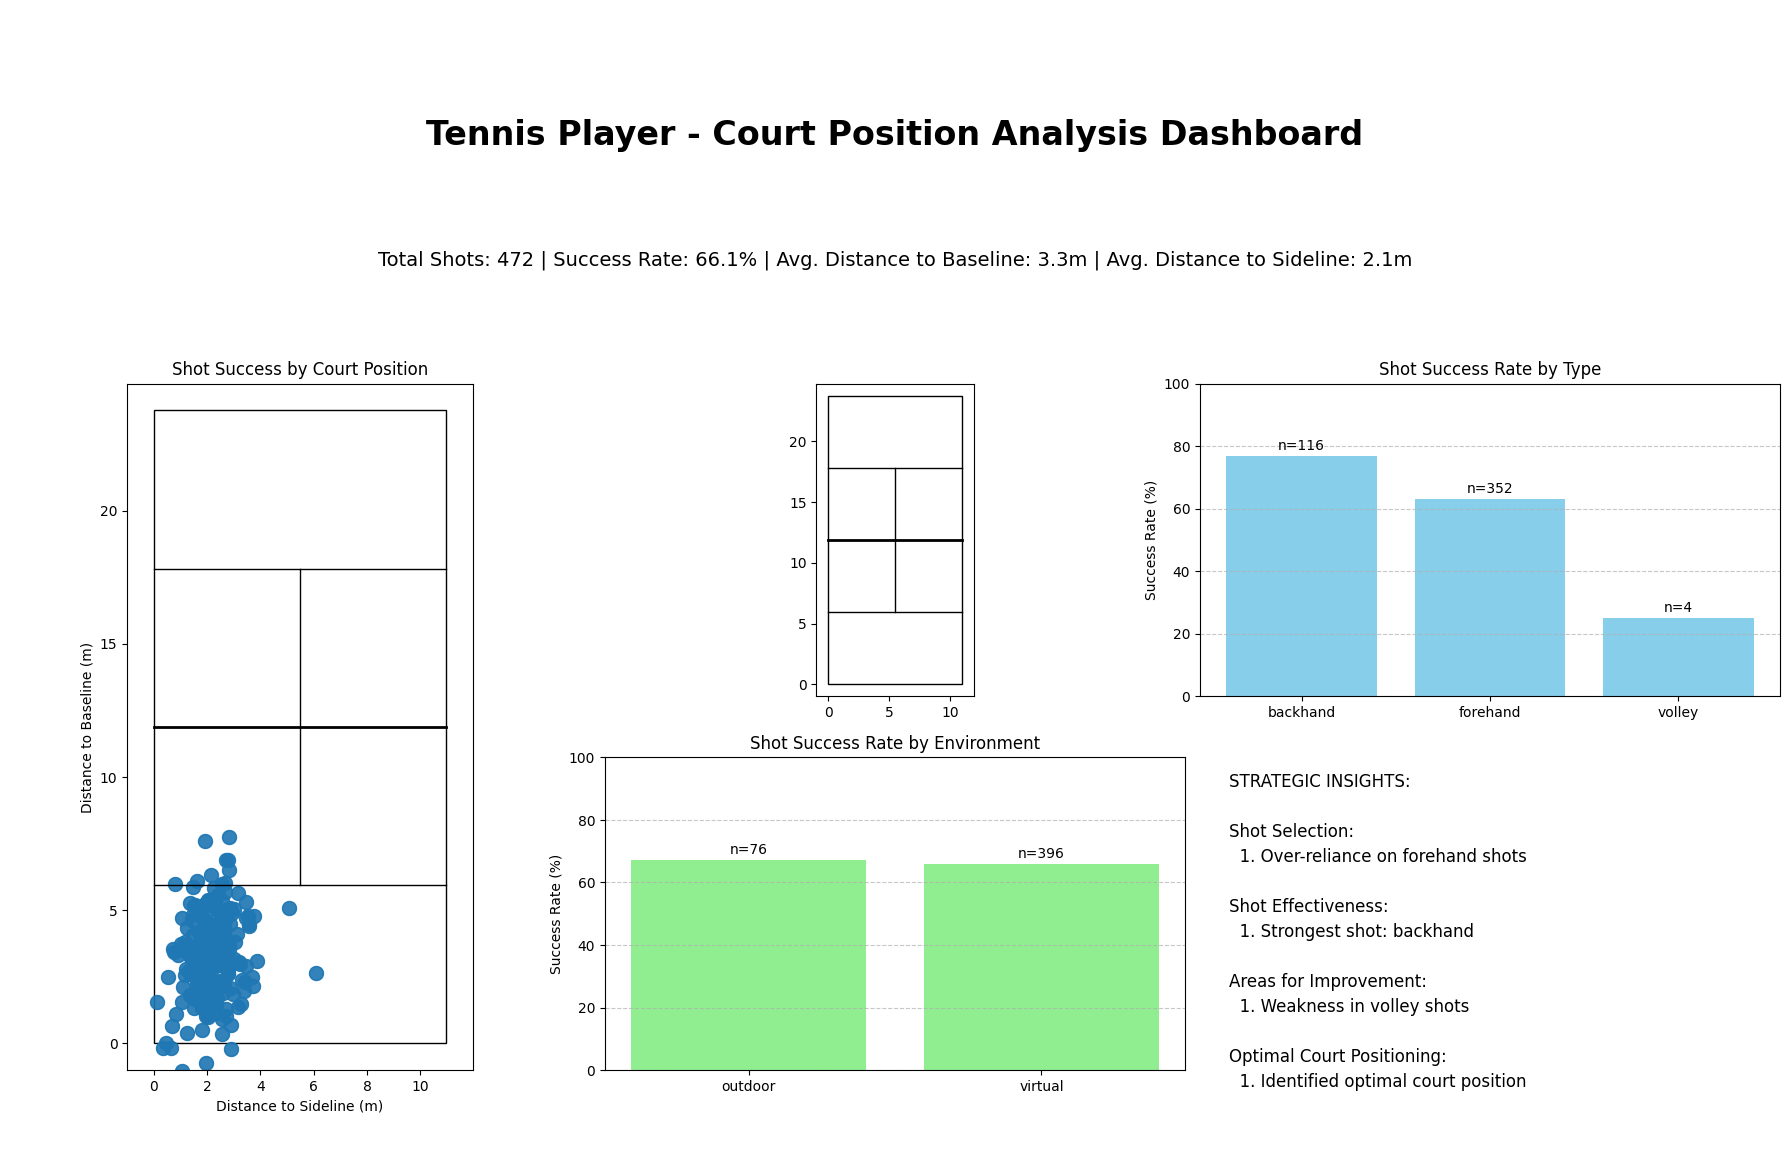

In [197]:

# Main function to run the complete position-based tennis analysis
def run_position_based_tennis_analysis(video_data, player_name="Player", output_dir="./perf"):
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Starting tennis position analysis for {player_name}...")
    
    # 1. Generate synthetic success data based on position
    print("Generating synthetic success estimates...")
    enhanced_data = generate_success_data(video_data)
    
    # 2. Analyze court positions
    print("Analyzing court positions...")
    position_metrics = analyze_court_positions(enhanced_data)
    
    # 3. Create visualizations
    print("Creating visualizations...")
    court_dimensions = {
        'width': 10.97,
        'length': 23.77
    }
    visualizations = visualize_court_positions(enhanced_data, court_dimensions)
    
    # 4. Create dashboard
    print("Creating position analysis dashboard...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    dashboard_path = os.path.join(output_dir, f"{player_name}_position_dashboard_{timestamp}.png")
    dashboard = create_position_dashboard(
        position_metrics,
        visualizations,
        player_name,
        dashboard_path
    )
    
    print(f"Analysis complete. Dashboard saved to: {dashboard_path}")
    
    # 5. Generate text report
    report_path = os.path.join(output_dir, f"{player_name}_position_analysis_{timestamp}.txt")
    insights = generate_position_insights(position_metrics)
    
    with open(report_path, 'w') as f:
        f.write(f"Tennis Position Analysis Report for {player_name}\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("SUMMARY STATISTICS:\n")
        f.write(f"Total Shots: {position_metrics.get('total_shots', 'N/A')}\n")
        f.write(f"Success Rate: {position_metrics.get('success_rate', 0):.1%}\n")
        f.write(f"Avg. Distance to Baseline: {position_metrics.get('avg_baseline_distance', 0):.1f}m\n")
        f.write(f"Avg. Distance to Sideline: {position_metrics.get('avg_sideline_distance', 0):.1f}m\n\n")
        
        f.write("SHOT TYPE DISTRIBUTION:\n")
        shot_dist = position_metrics.get('shot_type_distribution', {})
        for shot_type, count in shot_dist.items():
            percentage = count / position_metrics['total_shots'] if position_metrics['total_shots'] > 0 else 0
            f.write(f"{shot_type}: {count} shots ({percentage:.1%})\n")
        f.write("\n")
        
        f.write("STRATEGIC INSIGHTS:\n")
        for insight in insights:
            f.write(f"[{insight['category']}] {insight['insight']}\n")
            f.write(f"  {insight['description']}\n\n")
        
        f.write("\nThis analysis was generated automatically based on available court position data generated by members of group 09 for the subject Video Analytics.\n")
        f.write("Generated on: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    print(f"Analysis report saved to: {report_path}")
    
    return {
        'enhanced_data': enhanced_data,
        'position_metrics': position_metrics,
        'visualizations': visualizations,
        'dashboard': dashboard,
        'insights': insights,
        'dashboard_path': dashboard_path,
        'report_path': report_path
    }
results = run_position_based_tennis_analysis(video_data, "Tennis Player")